In [1]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.utils.vis_utils import plot_model
from keras.applications.mobilenet_v2 import decode_predictions
from keras.layers.normalization import BatchNormalization

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow
from time import time

import pandas

import pickle as pk

from keras.wrappers.scikit_learn import KerasClassifier

import numpy as np

seed = 7

Using TensorFlow backend.


## Hyperparameter runing on mobilenet with Adagrad.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3318000036505435058
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11280557671
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16007452530623568047
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


In [3]:
dir(keras.applications.mobilenet_v2)

['MobileNetV2',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'absolute_import',
 'decode_predictions',
 'division',
 'keras_modules_injection',
 'mobilenet_v2',
 'preprocess_input',
 'print_function']

In [4]:
np.random.seed(seed)

In [5]:
data_dir = '/data/oxford102/train'
train_data_dir = "/data/oxford102/train/"
validation_data_dir = "/data/oxford102/train/"
img_width, img_height = 256, 256
batch_size = 128
epochs = 100
nr_categories = 102
nb_train_samples = 4604
nb_validation_samples = 1094 

In [6]:
def get_image_generator(input_processor, img_aug=False):
    if not img_aug:
        train_val_datagen = ImageDataGenerator(preprocessing_function=input_processor, 
                                           validation_split=0.2)
    else: 
        train_val_datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            preprocessing_function=input_processor,
            validation_split=0.2)
        
    return train_val_datagen

In [7]:
def get_generators(batch_size, image_size, input_processor, img_aug=False):

    img_width, img_height = image_size
    
    train_val_datagen = get_image_generator(input_processor, img_aug)

    train_generator = train_val_datagen.flow_from_directory(
            train_data_dir,  # this is the target directory
            target_size=(img_width, img_height),  # all images will be resized to 250x250
            batch_size=batch_size,
            subset="training",
            class_mode='categorical')

    validation_generator = train_val_datagen.flow_from_directory(
            train_data_dir,  # this is the target directory
            target_size=(img_width, img_height),  # all images will be resized to 250x250
            subset="validation",
            batch_size=batch_size,
            class_mode='categorical')
    
    return train_generator, validation_generator


In [8]:
#from keras import regularizers

def get_model(network_name="inception_resnet_v2", image_size=(256, 256), verbose=False):
    k.set_learning_phase(0)

    img_width, img_height = image_size
    if network_name == "vgg16":
        base_model = keras.applications.vgg16.VGG16(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.vgg16.preprocess_input
    elif network_name == "vgg19":
        base_model = keras.applications.vgg19.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.vgg19.preprocess_input
    elif network_name == "inception_resnet_v2":
        base_model = keras.applications.inception_resnet_v2.InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.inception_resnet_v2.preprocess_input
    elif network_name == "mobilenet_v2":
        base_model = keras.applications.mobilenet_v2.MobileNetV2(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.mobilenet_v2.preprocess_input
    elif network_name == "mobilenet":
        base_model = keras.applications.mobilenet.MobileNet(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.mobilenet.preprocess_input
    elif network_name == "xception":
        base_model = keras.applications.xception.Xception(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.xception.preprocess_input
    elif network_name == "resnet50":
        base_model = keras.applications.resnet50.ResNet50(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.resnet50.preprocess_input
    elif network_name == "inception_v3":
        base_model = keras.applications.inception_v3.InceptionV3(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.inception_v3.preprocess_input
    elif network_name == "densenet201":
        base_model = keras.applications.densenet.DenseNet201(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.densenet.preprocess_input
    elif network_name == "nasnet":
        base_model = keras.applications.nasnet.NASNetLarge(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))
        input_processor = applications.nasnet.preprocess_input
    else:
        raise Exception("check your network name")

    for layer in base_model.layers[:]:
        layer.trainable = False

        #Adding custom Layers 
    k.set_learning_phase(1)
    x = base_model.output
    x = Flatten()(x)
    x = Dense(1024, activation="relu", 
              #kernel_regularizer=regularizers.l2(0.01),
             #       activity_regularizer=regularizers.l1(0.001)
             )(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x, training=True)
    #x = Dense(102, activation="relu")(x)
    predictions = Dense(nr_categories, activation="softmax")(x)

    _model = Model(input = base_model.input, output = predictions)
    if verbose:
        _model.summary()
    return _model, input_processor

In [9]:
def train_model(params, _model, generators):
    model_name = params["network_name"]
    num_train_img = 4604
    num_val_img = 1094

    np.random.seed(seed)
    log_time = time()
    params['log_time'] = log_time
    batch_size = params.get("batch_size")

    train_generator, validation_generator = generators
    _model.compile(loss = "categorical_crossentropy", optimizer = params["optimizer"], metrics=["accuracy"])


    base = '/data/oxford102/experiments'
    path = os.path.join(base, str(log_time))
    checkpoint = ModelCheckpoint(os.path.join(path, "{}_{}.h5".format(model_name, log_time)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
    tensorboard = TensorBoard(log_dir="logs/{}".format(log_time), histogram_freq=0, write_graph=True, write_images=True)
    csv_logger = CSVLogger(os.path.join(path, "{}_{}.csv".format(model_name, log_time)), append=True, separator=';')

    try:
        if not os.path.exists(path):
            os.makedirs(path)
        history_callback = _model.fit_generator(
                train_generator,
                steps_per_epoch=num_train_img // params["batch_size"] // 2,
                epochs=params["epochs"],
                validation_data=validation_generator,
                validation_steps=num_val_img // params["batch_size"],
                callbacks = [checkpoint, early, tensorboard, csv_logger])
    except Exception as e:
        raise(e)
    finally:
        params.pop("optimizer")
        pk.dump(params, open("experimental_params/experiments_{}.pk".format(log_time), "wb"), protocol=pk.HIGHEST_PROTOCOL)
        _model.save_weights(os.path.join(path, 'model_{}_weights_final_{}.h5'.format(model_name, log_time)))  # always save your weights after training or during training
        print(params)
        params
    return history_callback

In [10]:
# Hyperparameter optimization

In [11]:
optimizers

<module 'keras.optimizers' from '/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py'>

In [ ]:
optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [ ]:
optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

In [ ]:
optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [ ]:
optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)

In [ ]:
optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)

In [ ]:
optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

In [ ]:
optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)

In [10]:
#import talos as ta

# p = {'lr': (0.001, 0.01, 0.1),
#      'batch_size': (128),
#      'epochs': [150],
#      'dropout': (0, 0.5, 5),
#      'weight_regulizer':[None],
#      'emb_output_dims': [None],
#      'shape':['brick','long_funnel'],
#      'optimizer': [Adam, Nadam, RMSprop],
#      'losses': [logcosh, binary_crossentropy],
#      'activation':[relu, elu],
#      'last_activation': [sigmoid]}

In [9]:
# def train_model(params, _model, generators):
#     model_name = params["network_name"]
#     num_train_img = 4604
#     num_val_img = 1094

#     np.random.seed(seed)
#     log_time = time()
#     params['log_time'] = log_time
#     batch_size = params.get("batch_size")

#     train_generator, validation_generator = generators
#     _model.compile(loss = "categorical_crossentropy", optimizer = params["optimizer"], metrics=["accuracy"])


#     base = '/data/oxford102/experiments'
#     path = os.path.join(base, str(log_time))
#     checkpoint = ModelCheckpoint(os.path.join(path, "{}_{}.h5".format(model_name, log_time)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
#     early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
#     tensorboard = TensorBoard(log_dir="logs/{}".format(log_time), histogram_freq=0, write_graph=True, write_images=True)
#     csv_logger = CSVLogger(os.path.join(path, "{}_{}.csv".format(model_name, log_time)), append=True, separator=';')

#     try:
#         if not os.path.exists(path):
#             os.makedirs(path)
#         history_callback = _model.fit_generator(
#                 train_generator,
#                 steps_per_epoch=num_train_img // params["batch_size"] // 2,
#                 epochs=params["epochs"],
#                 validation_data=validation_generator,
#                 validation_steps=num_val_img // params["batch_size"],
#                 callbacks = [checkpoint, early, tensorboard, csv_logger])
#     except Exception as e:
#         raise(e)
#     finally:
#         params.pop("optimizer")
#         pk.dump(params, open("experimental_params/experiments_{}.pk".format(log_time), "wb"), protocol=pk.HIGHEST_PROTOCOL)
#         _model.save_weights(os.path.join(path, 'model_{}_weights_final_{}.h5'.format(model_name, log_time)))  # always save your weights after training or during training
#         print(params)
#         params

# MobileNet + adagrad

In [10]:
import itertools
import numpy

In [11]:
lr = [0.1, 0.01, 0.001]
rho = [0.5, 0.75, 0.9]
epsilon = [None, 1e-06, 1e-04, 1e-02]
decay = [0.001, 0.01, 0.1, 0.2]


In [12]:
# from keras import backend as K
# K.epsilon()
# >>> 1e-7

In [13]:
grid = list(itertools.product(lr, rho, epsilon, decay))

In [14]:
grid

[(0.1, 0.5, None, 0.001),
 (0.1, 0.5, None, 0.01),
 (0.1, 0.5, None, 0.1),
 (0.1, 0.5, None, 0.2),
 (0.1, 0.5, 1e-06, 0.001),
 (0.1, 0.5, 1e-06, 0.01),
 (0.1, 0.5, 1e-06, 0.1),
 (0.1, 0.5, 1e-06, 0.2),
 (0.1, 0.5, 0.0001, 0.001),
 (0.1, 0.5, 0.0001, 0.01),
 (0.1, 0.5, 0.0001, 0.1),
 (0.1, 0.5, 0.0001, 0.2),
 (0.1, 0.5, 0.01, 0.001),
 (0.1, 0.5, 0.01, 0.01),
 (0.1, 0.5, 0.01, 0.1),
 (0.1, 0.5, 0.01, 0.2),
 (0.1, 0.75, None, 0.001),
 (0.1, 0.75, None, 0.01),
 (0.1, 0.75, None, 0.1),
 (0.1, 0.75, None, 0.2),
 (0.1, 0.75, 1e-06, 0.001),
 (0.1, 0.75, 1e-06, 0.01),
 (0.1, 0.75, 1e-06, 0.1),
 (0.1, 0.75, 1e-06, 0.2),
 (0.1, 0.75, 0.0001, 0.001),
 (0.1, 0.75, 0.0001, 0.01),
 (0.1, 0.75, 0.0001, 0.1),
 (0.1, 0.75, 0.0001, 0.2),
 (0.1, 0.75, 0.01, 0.001),
 (0.1, 0.75, 0.01, 0.01),
 (0.1, 0.75, 0.01, 0.1),
 (0.1, 0.75, 0.01, 0.2),
 (0.1, 0.9, None, 0.001),
 (0.1, 0.9, None, 0.01),
 (0.1, 0.9, None, 0.1),
 (0.1, 0.9, None, 0.2),
 (0.1, 0.9, 1e-06, 0.001),
 (0.1, 0.9, 1e-06, 0.01),
 (0.1, 0.9, 1e-0

In [7]:
choices = numpy.random.choice(range(len(grid)), int(len(grid)*0.2), replace=False)

In [8]:
# choices
# >>> array([ 11, 122,  37,  32,  70, 113,  77, 116, 134,  74, 143,  66,  41,
#         81, 102,  97,  62,  49,  51,  80,  36,  91,  65,  98,  76, 135,
#         40,  45])

In [11]:
choices = np.array([ 11, 122,  37,  32,  70, 113,  77, 116, 134,  74, 143,  66,  41,
        81, 102,  97,  62,  49,  51,  80,  36,  91,  65,  98,  76, 135,
        40,  45])

In [ ]:
choices = np.array([11, 32, 36, 37, 40, 41, 45, 49, 51, 62, 65, 66, 70, 74, 76, 77, 80, 81, 91, 97, 98, 102, 113, 116, 122, 134, 135, 143])

In [27]:
params = {'network_name': "mobilenet_v2",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [26]:
_optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 20s 1s/step - loss: 2.5101 - acc: 0.4504 - val_loss: 1.5273 - val_acc: 0.6328

Epoch 00001: val_acc improved from -inf to 0.63281, saving model to /data/oxford102/experiments/1546265924.8866432/mobilenet_v2_1546265924.8866432.h5
Epoch 2/100
17/17 [==============================] - 9s 541ms/step - loss: 1.2092 - acc: 0.7073 - val_loss: 1.0390 - val_acc: 0.7226

Epoch 00002: val_acc improved from 0.63281 to 0.72257, saving model to /data/oxford102/experiments/1546265924.8866432/mobilenet_v2_1546265924.8866432.h5
Epoch 3/100
17/17 [==============================] - 13s 767ms/step - loss: 0.3889 - acc: 0.9183 - val_loss: 0.7759 - val_acc: 0.8033

Epoch 00003: val_acc improved from 0.72257 to 0.80331, saving model to /data/oxford102/experiments/1546265924.8866432/mobilenet_v2_1546265924.8866432.h5
Epoch 4/100
17/17 [==============================] - 14

In [27]:
params = {'network_name': "vgg16",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [28]:
_optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

58892288/58889256 [==============================] - 1s 0us/step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 38s 2s/step - loss: 2.3898 - acc: 0.4839 - val_loss: 1.4045 - val_acc: 0.6621

Epoch 00001: val_acc improved from -inf to 0.66211, saving model to /data/oxford102/experiments/1546266222.6804273/vgg16_1546266222.6804273.h5
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 1.0890 - acc: 0.7367 - val_loss: 0.9688 - val_acc: 0.7578

Epoch 00002: val_acc improved from 0.66211 to 0.75776, saving model to /data/oxford102/experiments/1546266222.6804273/vgg16_1546266222.6804273.h5
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 0.2759 - acc: 0.9538 - val_loss: 0.8252 - val_acc: 0.7992

Epoch 00003: val_acc improved from 0.75776 to 0.79917, saving model to /data/oxford102/experiments/1546266222.6804273/vgg16_1546266222.6804273.h5
Epoch 4/100
17/17 [==============================] - 28s 2s/step - loss: 0.1377 -

In [ ]:
params = {'network_name': "vgg16",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [ ]:
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

In [29]:
params = {'network_name': "vgg19",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [30]:
_optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 34s 2s/step - loss: 2.4160 - acc: 0.4738 - val_loss: 1.4415 - val_acc: 0.6650

Epoch 00001: val_acc improved from -inf to 0.66504, saving model to /data/oxford102/experiments/1546266538.4235597/vgg19_1546266538.4235597.h5
Epoch 2/100
17/17 [==============================] - 32s 2s/step - loss: 1.1344 - acc: 0.7215 - val_loss: 1.0210 - val_acc: 0.7557

Epoch 00002: val_acc improved from 0.66504 to 0.75569, saving model to /data/oxford102/experiments/1546266538.4235597/vgg19_1546266538.4235597.h5
Epoch 3/100
17/17 [==============================] - 32s 2s/step - loss: 0.2891 - acc: 0.9509 - val_loss: 0.8713 - val_acc: 0.7785

Epoch 00003: val_acc improved from 0.75569 to 0.77847, saving model to /data/oxford102/experiments/1546266538.4235597/vgg19_1546266538.4235597.h5
Epoch 4/100
17/17 [==============================] - 32s 2s/step - loss: 0.1565 -

In [ ]:
params = {'network_name': "vgg19",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [ ]:
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

In [31]:
params = {'network_name': "inception_resnet_v2",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [32]:
_optimizer = optimizers.Adagrad(lr=0.01, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 43s 3s/step - loss: 3.3648 - acc: 0.2564 - val_loss: 2.5377 - val_acc: 0.3652

Epoch 00001: val_acc improved from -inf to 0.36523, saving model to /data/oxford102/experiments/1546266852.4233403/inception_resnet_v2_1546266852.4233403.h5
Epoch 2/100
17/17 [==============================] - 36s 2s/step - loss: 2.3679 - acc: 0.4205 - val_loss: 2.0556 - val_acc: 0.4731

Epoch 00002: val_acc improved from 0.36523 to 0.47308, saving model to /data/oxford102/experiments/1546266852.4233403/inception_resnet_v2_1546266852.4233403.h5
Epoch 3/100
17/17 [==============================] - 37s 2s/step - loss: 1.5736 - acc: 0.6048 - val_loss: 1.7424 - val_acc: 0.5538

Epoch 00003: val_acc improved from 0.47308 to 0.55383, saving model to /data/oxford102/experiments/1546266852.4233403/inception_resnet_v2_1546266852.4233403.h5
Epoch 4/100
17/17 [====================

In [ ]:
params = {'network_name': "inception_resnet_v2",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [ ]:
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 21s 1s/step - loss: 2.4524 - acc: 0.4908 - val_loss: 1.4668 - val_acc: 0.6797

Epoch 00001: val_acc improved from -inf to 0.67969, saving model to /data/oxford102/experiments/1549159357.807975/mobilenet_1549159357.807975.h5
Epoch 2/100
17/17 [==============================] - 16s 970ms/step - loss: 1.1428 - acc: 0.7698 - val_loss: 0.9986 - val_acc: 0.8137

Epoch 00002: val_acc improved from 0.67969 to 0.81366, saving model to /data/oxford102/experiments/1549159357.807975/mobilenet_1549159357.807975.h5
Epoch 3/100
17/17 [==============================] - 13s 783ms/step - loss: 0.3079 - acc: 0.9717 - val_loss: 0.8415 - val_acc: 0.8219

Epoch 00003: val_acc improved from 0.81366 to 0.82195, saving model to /data/oxford102/experiments/1549159357.807975/mobilenet_1549159357.807975.h5
Epoch 4/100
17/17 [==============================] - 15s 875ms/step -

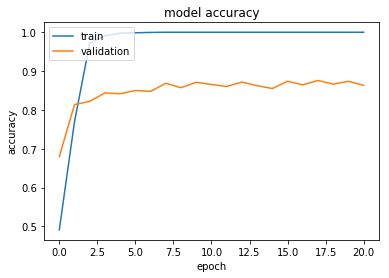

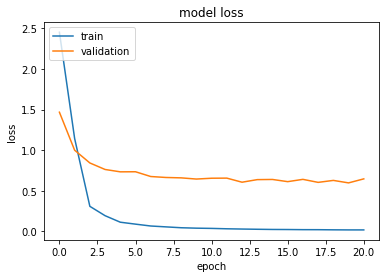

In [10]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 38s 2s/step - loss: 3.0133 - acc: 0.3520 - val_loss: 2.0993 - val_acc: 0.4922

Epoch 00001: val_acc improved from -inf to 0.49219, saving model to /data/oxford102/experiments/1549159712.0286183/xception_1549159712.0286183.h5
Epoch 2/100
17/17 [==============================] - 34s 2s/step - loss: 1.8320 - acc: 0.5763 - val_loss: 1.5545 - val_acc: 0.6522

Epoch 00002: val_acc improved from 0.49219 to 0.65217, saving model to /data/oxford102/experiments/1549159712.0286183/xception_1549159712.0286183.h5
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 0.9572 - acc: 0.8175 - val_loss: 1.3462 - val_acc: 0.7091

Epoch 00003: val_acc improved from 0.65217 to 0.70911, saving model to /data/oxford102/experiments/1549159712.0286183/xception_1549159712.0286183.h5
Epoch 4/100
17/17 [==============================] - 32s 2s/step - loss:

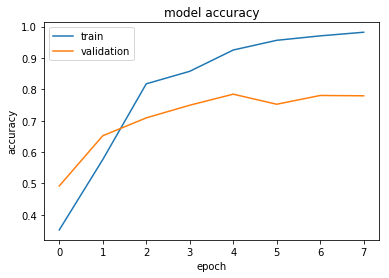

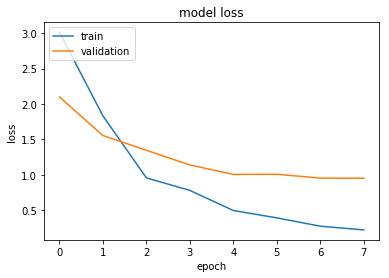

In [11]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 25s 1s/step - loss: 2.3006 - acc: 0.5051 - val_loss: 1.2869 - val_acc: 0.7295

Epoch 00001: val_acc improved from -inf to 0.72949, saving model to /data/oxford102/experiments/1549161286.8505864/resnet50_1549161286.8505864.h5
Epoch 2/100
17/17 [==============================] - 24s 1s/step - loss: 1.0157 - acc: 0.7831 - val_loss: 0.9278 - val_acc: 0.7961

Epoch 00002: val_acc improved from 0.72949 to 0.79607, saving model to /data/oxford102/experiments/1549161286.8505864/resnet50_1549161286.8505864.h5
Epoch 3/100
17/17 [==============================] - 25s 1s/step - loss: 0.2394 - acc: 0.9740 - val_loss: 0.7543 - val_acc: 0.8282

Epoch 00003: val_acc improved from 0.79607 to 0.82816, saving model to /data/oxford102/experiments/1549161286.8505864/resnet50_1549161286.8505864.h5
Epoch 4/100
17/17 [==============================] - 22s 1s/step - loss:

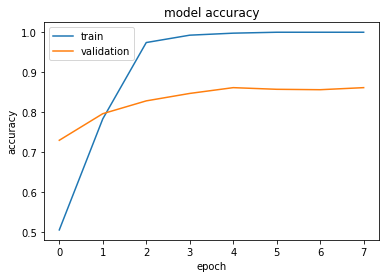

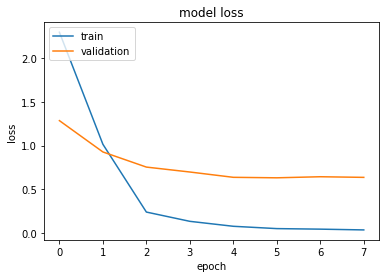

In [13]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 22s 1s/step - loss: 3.1689 - acc: 0.3281 - val_loss: 2.3413 - val_acc: 0.4795

Epoch 00001: val_acc improved from -inf to 0.47949, saving model to /data/oxford102/experiments/1549161563.9038854/inception_v3_1549161563.9038854.h5
Epoch 2/100
17/17 [==============================] - 17s 1s/step - loss: 2.0089 - acc: 0.5528 - val_loss: 1.7451 - val_acc: 0.6201

Epoch 00002: val_acc improved from 0.47949 to 0.62008, saving model to /data/oxford102/experiments/1549161563.9038854/inception_v3_1549161563.9038854.h5
Epoch 3/100
17/17 [==============================] - 18s 1s/step - loss: 1.0905 - acc: 0.8045 - val_loss: 1.5378 - val_acc: 0.6491

Epoch 00003: val_acc improved from 0.62008 to 0.64907, saving model to /data/oxford102/experiments/1549161563.9038854/inception_v3_1549161563.9038854.h5
Epoch 4/100
17/17 [==============================] - 16s 916

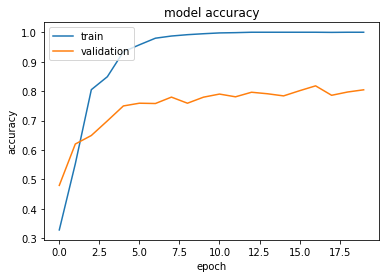

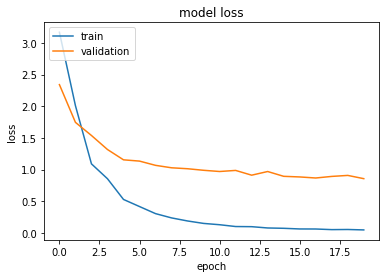

In [14]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 46s 3s/step - loss: 2.5525 - acc: 0.4807 - val_loss: 1.5442 - val_acc: 0.6855

Epoch 00001: val_acc improved from -inf to 0.68555, saving model to /data/oxford102/experiments/1549162063.9402719/densenet201_1549162063.9402719.h5
Epoch 2/100
17/17 [==============================] - 36s 2s/step - loss: 1.2675 - acc: 0.7675 - val_loss: 1.0204 - val_acc: 0.8219

Epoch 00002: val_acc improved from 0.68555 to 0.82195, saving model to /data/oxford102/experiments/1549162063.9402719/densenet201_1549162063.9402719.h5
Epoch 3/100
17/17 [==============================] - 38s 2s/step - loss: 0.4437 - acc: 0.9616 - val_loss: 0.8297 - val_acc: 0.8571

Epoch 00003: val_acc improved from 0.82195 to 0.85714, saving model to /data/oxford102/experiments/1549162063.9402719/densenet201_1549162063.9402719.h5
Epoch 4/100
17/17 [==============================] - 32s 2s/ste

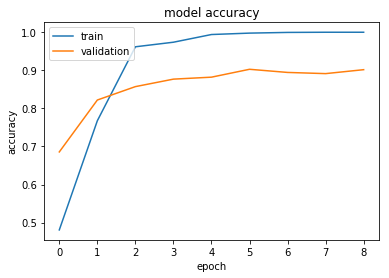

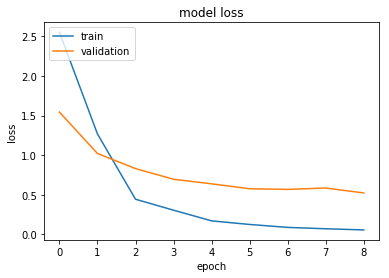

In [15]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 104s 6s/step - loss: 2.9523 - acc: 0.3575 - val_loss: 2.1876 - val_acc: 0.5010

Epoch 00001: val_acc improved from -inf to 0.50098, saving model to /data/oxford102/experiments/1549163512.928829/nasnet_1549163512.928829.h5
Epoch 2/100
17/17 [==============================] - 92s 5s/step - loss: 1.8942 - acc: 0.5533 - val_loss: 1.6688 - val_acc: 0.6035

Epoch 00002: val_acc improved from 0.50098 to 0.60352, saving model to /data/oxford102/experiments/1549163512.928829/nasnet_1549163512.928829.h5
Epoch 3/100
17/17 [==============================] - 94s 6s/step - loss: 0.7954 - acc: 0.8367 - val_loss: 1.5154 - val_acc: 0.6159

Epoch 00003: val_acc improved from 0.60352 to 0.61594, saving model to /data/oxford102/experiments/1549163512.928829/nasnet_1549163512.928829.h5
Epoch 4/100
17/17 [==============================] - 92s 5s/step - loss: 0.5941 - a

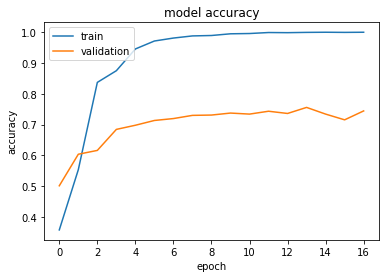

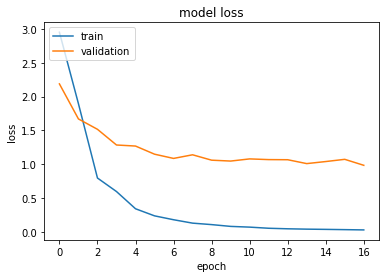

In [10]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "adagrad", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adagrad(lr=0.001, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Adadelta

In [10]:
params = {'network_name': "mobilenet_v2",
         'image_aug': False,
         'optimizer_name': "adagdelta", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [34]:
lr, epsilon, decay = (0.01, None, 0.0)
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 18s 1s/step - loss: 4.9817 - acc: 0.0395 - val_loss: 4.4178 - val_acc: 0.0830

Epoch 00001: val_acc improved from -inf to 0.08301, saving model to /data/oxford102/experiments/1546267945.754025/mobilenet_v2_1546267945.754025.h5
Epoch 2/100
17/17 [==============================] - 9s 543ms/step - loss: 4.0254 - acc: 0.1420 - val_loss: 3.6703 - val_acc: 0.2019

Epoch 00002: val_acc improved from 0.08301 to 0.20186, saving model to /data/oxford102/experiments/1546267945.754025/mobilenet_v2_1546267945.754025.h5
Epoch 3/100
17/17 [==============================] - 12s 678ms/step - loss: 2.9283 - acc: 0.3488 - val_loss: 3.2601 - val_acc: 0.2899

Epoch 00003: val_acc improved from 0.20186 to 0.28986, saving model to /data/oxford102/experiments/1546267945.754025/mobilenet_v2_1546267945.754025.h5
Epoch 4/100
17/17 [==============================] - 13s 787m

In [35]:
params['network_name'] = "inception_resnet_v2"
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 42s 2s/step - loss: 4.8742 - acc: 0.0423 - val_loss: 4.3529 - val_acc: 0.0850

Epoch 00001: val_acc improved from -inf to 0.08496, saving model to /data/oxford102/experiments/1546268556.0703526/inception_resnet_v2_1546268556.0703526.h5
Epoch 2/100
17/17 [==============================] - 35s 2s/step - loss: 4.0917 - acc: 0.1314 - val_loss: 3.6941 - val_acc: 0.1656

Epoch 00002: val_acc improved from 0.08496 to 0.16563, saving model to /data/oxford102/experiments/1546268556.0703526/inception_resnet_v2_1546268556.0703526.h5
Epoch 3/100
17/17 [==============================] - 35s 2s/step - loss: 3.3010 - acc: 0.2568 - val_loss: 3.2608 - val_acc: 0.2578

Epoch 00003: val_acc improved from 0.16563 to 0.25776, saving model to /data/oxford102/experiments/1546268556.0703526/inception_resnet_v2_1546268556.0703526.h5
Epoch 4/100
17/17 [====================

In [11]:
params['network_name'] = "vgg16"
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 38s 2s/step - loss: 5.3186 - acc: 0.0124 - val_loss: 5.2461 - val_acc: 0.0107

Epoch 00001: val_acc improved from -inf to 0.01074, saving model to /data/oxford102/experiments/1546270611.0157263/vgg16_1546270611.0157263.h5
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 5.0722 - acc: 0.0267 - val_loss: 5.0202 - val_acc: 0.0197

Epoch 00002: val_acc improved from 0.01074 to 0.01967, saving model to /data/oxford102/experiments/1546270611.0157263/vgg16_1546270611.0157263.h5
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 4.6364 - acc: 0.0543 - val_loss: 4.6999 - val_acc: 0.0424

Epoch 00003: val_acc improved from 0.01967 to 0.04244, saving model to /data/oxford102/experiments/1546270611.0157263/vgg16_1546270611.0157263.h5
Epoch 4/100
17/17 [==============================] - 28s 2s/step - loss: 4.3913 -

Epoch 32/100
17/17 [==============================] - 28s 2s/step - loss: 0.9988 - acc: 0.8532 - val_loss: 2.3451 - val_acc: 0.4886

Epoch 00032: val_acc did not improve from 0.51346
Epoch 33/100
17/17 [==============================] - 28s 2s/step - loss: 0.9519 - acc: 0.8695 - val_loss: 2.1127 - val_acc: 0.5373

Epoch 00033: val_acc improved from 0.51346 to 0.53727, saving model to /data/oxford102/experiments/1546270611.0157263/vgg16_1546270611.0157263.h5
Epoch 34/100
17/17 [==============================] - 28s 2s/step - loss: 0.9438 - acc: 0.8716 - val_loss: 2.1885 - val_acc: 0.5104

Epoch 00034: val_acc did not improve from 0.53727
Epoch 35/100
17/17 [==============================] - 28s 2s/step - loss: 0.8884 - acc: 0.8906 - val_loss: 2.1396 - val_acc: 0.5248

Epoch 00035: val_acc did not improve from 0.53727
Epoch 36/100
17/17 [==============================] - 28s 2s/step - loss: 0.8758 - acc: 0.8845 - val_loss: 2.0965 - val_acc: 0.5383

Epoch 00036: val_acc improved from 0.53

In [12]:
params['network_name'] = "vgg19"
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 34s 2s/step - loss: 5.3990 - acc: 0.0119 - val_loss: 5.3062 - val_acc: 0.0176

Epoch 00001: val_acc improved from -inf to 0.01758, saving model to /data/oxford102/experiments/1546272025.2986946/vgg19_1546272025.2986946.h5
Epoch 2/100
17/17 [==============================] - 32s 2s/step - loss: 5.1076 - acc: 0.0221 - val_loss: 4.9282 - val_acc: 0.0404

Epoch 00002: val_acc improved from 0.01758 to 0.04037, saving model to /data/oxford102/experiments/1546272025.2986946/vgg19_1546272025.2986946.h5
Epoch 3/100
17/17 [==============================] - 32s 2s/step - loss: 4.6636 - acc: 0.0497 - val_loss: 4.7241 - val_acc: 0.0487

Epoch 00003: val_acc improved from 0.04037 to 0.04865, saving model to /data/oxford102/experiments/1546272025.2986946/vgg19_1546272025.2986946.h5
Epoch 4/100
17/17 [==============================] - 32s 2s/step - loss: 4.3632 -

Epoch 34/100
17/17 [==============================] - 32s 2s/step - loss: 0.9839 - acc: 0.8472 - val_loss: 2.1930 - val_acc: 0.5083

Epoch 00034: val_acc did not improve from 0.52381
Epoch 35/100
17/17 [==============================] - 32s 2s/step - loss: 0.8987 - acc: 0.8847 - val_loss: 2.1343 - val_acc: 0.5300

Epoch 00035: val_acc improved from 0.52381 to 0.53002, saving model to /data/oxford102/experiments/1546272025.2986946/vgg19_1546272025.2986946.h5
Epoch 36/100
17/17 [==============================] - 32s 2s/step - loss: 0.8865 - acc: 0.8684 - val_loss: 2.1323 - val_acc: 0.5352

Epoch 00036: val_acc improved from 0.53002 to 0.53520, saving model to /data/oxford102/experiments/1546272025.2986946/vgg19_1546272025.2986946.h5
Epoch 37/100
17/17 [==============================] - 32s 2s/step - loss: 0.8302 - acc: 0.9017 - val_loss: 2.0710 - val_acc: 0.5488

Epoch 00037: val_acc improved from 0.53520 to 0.54883, saving model to /data/oxford102/experiments/1546272025.2986946/vgg19_15

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 17s 981ms/step - loss: 5.1362 - acc: 0.0262 - val_loss: 4.7425 - val_acc: 0.0547

Epoch 00001: val_acc improved from -inf to 0.05469, saving model to /data/oxford102/experiments/1549165547.4277332/mobilenet_1549165547.4277332.h5
Epoch 2/100
17/17 [==============================] - 9s 520ms/step - loss: 4.4093 - acc: 0.0878 - val_loss: 3.9933 - val_acc: 0.1356

Epoch 00002: val_acc improved from 0.05469 to 0.13561, saving model to /data/oxford102/experiments/1549165547.4277332/mobilenet_1549165547.4277332.h5
Epoch 3/100
17/17 [==============================] - 12s 720ms/step - loss: 3.3477 - acc: 0.2452 - val_loss: 3.5697 - val_acc: 0.2091

Epoch 00003: val_acc improved from 0.13561 to 0.20911, saving model to /data/oxford102/experiments/1549165547.4277332/mobilenet_1549165547.4277332.h5
Epoch 4/100
17/17 [==============================] - 13s 750m

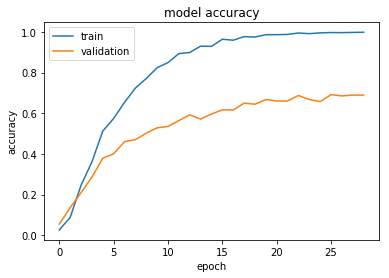

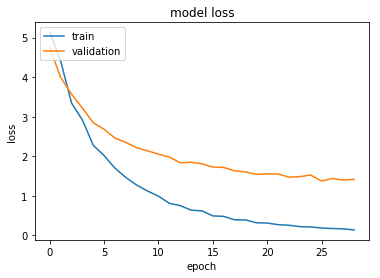

In [11]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "Adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 40s 2s/step - loss: 4.3381 - acc: 0.1158 - val_loss: 3.4352 - val_acc: 0.2490

Epoch 00001: val_acc improved from -inf to 0.24902, saving model to /data/oxford102/experiments/1549166099.9875085/xception_1549166099.9875085.h5
Epoch 2/100
17/17 [==============================] - 35s 2s/step - loss: 3.1098 - acc: 0.3010 - val_loss: 2.6757 - val_acc: 0.3882

Epoch 00002: val_acc improved from 0.24902 to 0.38820, saving model to /data/oxford102/experiments/1549166099.9875085/xception_1549166099.9875085.h5
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 2.1429 - acc: 0.5123 - val_loss: 2.3166 - val_acc: 0.4617

Epoch 00003: val_acc improved from 0.38820 to 0.46170, saving model to /data/oxford102/experiments/1549166099.9875085/xception_1549166099.9875085.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/step - loss:

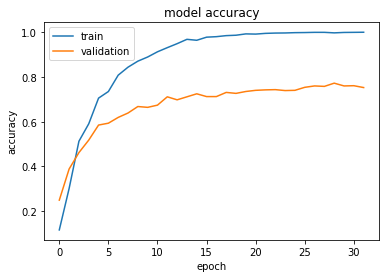

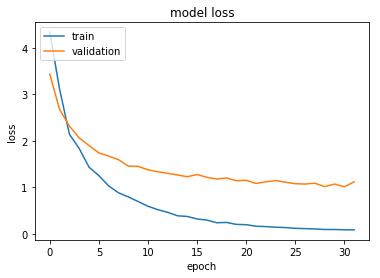

In [12]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "Adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 30s 2s/step - loss: 4.9200 - acc: 0.0450 - val_loss: 4.2549 - val_acc: 0.1172

Epoch 00001: val_acc improved from -inf to 0.11719, saving model to /data/oxford102/experiments/1549167512.793755/resnet50_1549167512.793755.h5
Epoch 2/100
17/17 [==============================] - 26s 2s/step - loss: 3.8012 - acc: 0.1861 - val_loss: 3.3855 - val_acc: 0.2505

Epoch 00002: val_acc improved from 0.11719 to 0.25052, saving model to /data/oxford102/experiments/1549167512.793755/resnet50_1549167512.793755.h5
Epoch 3/100
17/17 [==============================] - 26s 2s/step - loss: 2.5266 - acc: 0.4579 - val_loss: 2.9262 - val_acc: 0.3675

Epoch 00003: val_acc improved from 0.25052 to 0.36749, saving model to /data/oxford102/experiments/1549167512.793755/resnet50_1549167512.793755.h5
Epoch 4/100
17/17 [==============================] - 24s 1s/step - loss: 2.103

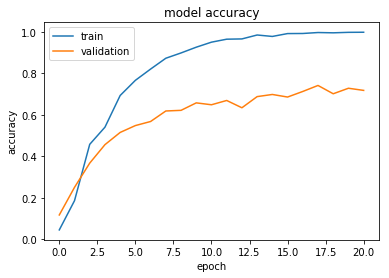

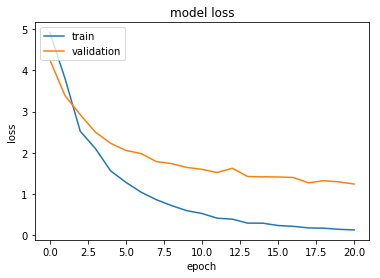

In [13]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "Adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 23s 1s/step - loss: 4.8762 - acc: 0.0473 - val_loss: 4.3518 - val_acc: 0.0889

Epoch 00001: val_acc improved from -inf to 0.08887, saving model to /data/oxford102/experiments/1549168335.625167/inception_v3_1549168335.625167.h5
Epoch 2/100
17/17 [==============================] - 18s 1s/step - loss: 4.0247 - acc: 0.1425 - val_loss: 3.7098 - val_acc: 0.1925

Epoch 00002: val_acc improved from 0.08887 to 0.19255, saving model to /data/oxford102/experiments/1549168335.625167/inception_v3_1549168335.625167.h5
Epoch 3/100
17/17 [==============================] - 19s 1s/step - loss: 3.0911 - acc: 0.3069 - val_loss: 3.2047 - val_acc: 0.2930

Epoch 00003: val_acc improved from 0.19255 to 0.29296, saving model to /data/oxford102/experiments/1549168335.625167/inception_v3_1549168335.625167.h5
Epoch 4/100
17/17 [==============================] - 16s 952ms/ste

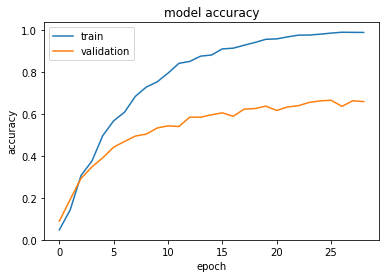

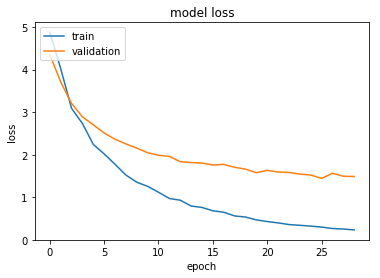

In [14]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "Adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
params = {'network_name': "densenet201", 
         'image_aug': False,
         'optimizer_name': "Adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
{'network_name': 'densenet201', 'image_aug': False, 'optimizer_name': 'Adadelta', 'optimizer_params': None, 'batch_size': 128, 'epochs': 100, 'image_size': (224, 224), 'log_time': 1549169177.0473442}


ResourceExhaustedError: OOM when allocating tensor with shape[128,64,112,112] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node conv1/conv/convolution}} = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="VALID", strides=[1, 1, 2, 2], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv1/conv/convolution-0-TransposeNHWCToNCHW-LayoutOptimizer, conv1/conv/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics_5/acc/Mean/_33201}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4729_metrics_5/acc/Mean", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


In [ ]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "Adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 21s 1s/step - loss: 5.0774 - acc: 0.0276 - val_loss: 4.6408 - val_acc: 0.0527

Epoch 00001: val_acc improved from -inf to 0.05273, saving model to /data/oxford102/experiments/1549207318.8028562/mobilenet_1549207318.8028562.h5
Epoch 2/100
17/17 [==============================] - 20s 1s/step - loss: 4.3636 - acc: 0.0942 - val_loss: 3.9997 - val_acc: 0.1356

Epoch 00002: val_acc improved from 0.05273 to 0.13561, saving model to /data/oxford102/experiments/1549207318.8028562/mobilenet_1549207318.8028562.h5
Epoch 3/100
17/17 [==============================] - 13s 791ms/step - loss: 3.3918 - acc: 0.2517 - val_loss: 3.5099 - val_acc: 0.2402

Epoch 00003: val_acc improved from 0.13561 to 0.24017, saving model to /data/oxford102/experiments/1549207318.8028562/mobilenet_1549207318.8028562.h5
Epoch 4/100
17/17 [==============================] - 13s 778ms/ste

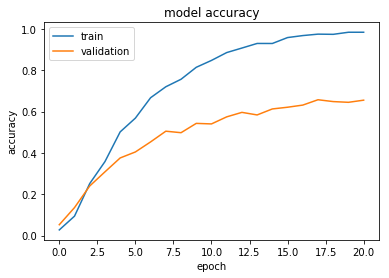

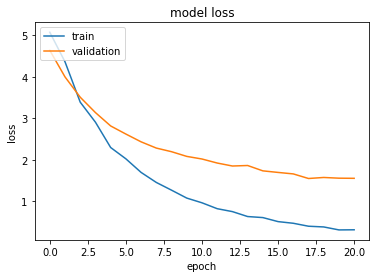

In [10]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 39s 2s/step - loss: 4.3717 - acc: 0.1158 - val_loss: 3.5818 - val_acc: 0.2100

Epoch 00001: val_acc improved from -inf to 0.20996, saving model to /data/oxford102/experiments/1549219277.1254125/xception_1549219277.1254125.h5
Epoch 2/100
17/17 [==============================] - 38s 2s/step - loss: 3.1313 - acc: 0.3051 - val_loss: 2.7550 - val_acc: 0.3892

Epoch 00002: val_acc improved from 0.20996 to 0.38923, saving model to /data/oxford102/experiments/1549219277.1254125/xception_1549219277.1254125.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 2.0802 - acc: 0.5306 - val_loss: 2.4099 - val_acc: 0.4420

Epoch 00003: val_acc improved from 0.38923 to 0.44203, saving model to /data/oxford102/experiments/1549219277.1254125/xception_1549219277.1254125.h5
Epoch 4/100
17/17 [==============================] - 35s 2s/step - loss:

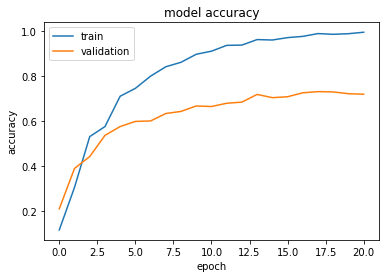

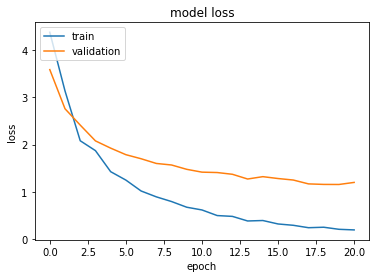

In [12]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 30s 2s/step - loss: 4.8791 - acc: 0.0414 - val_loss: 4.2318 - val_acc: 0.1064

Epoch 00001: val_acc improved from -inf to 0.10645, saving model to /data/oxford102/experiments/1549220270.3358254/resnet50_1549220270.3358254.h5
Epoch 2/100
17/17 [==============================] - 26s 2s/step - loss: 3.8351 - acc: 0.1714 - val_loss: 3.3688 - val_acc: 0.2692

Epoch 00002: val_acc improved from 0.10645 to 0.26915, saving model to /data/oxford102/experiments/1549220270.3358254/resnet50_1549220270.3358254.h5
Epoch 3/100
17/17 [==============================] - 27s 2s/step - loss: 2.5883 - acc: 0.4287 - val_loss: 2.8901 - val_acc: 0.3644

Epoch 00003: val_acc improved from 0.26915 to 0.36439, saving model to /data/oxford102/experiments/1549220270.3358254/resnet50_1549220270.3358254.h5
Epoch 4/100
17/17 [==============================] - 25s 1s/step - loss:

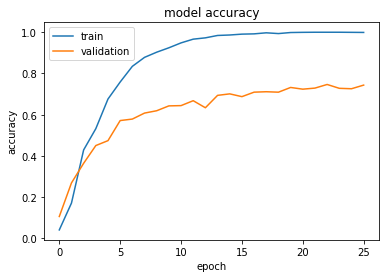

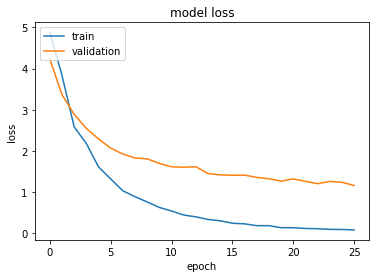

In [13]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 24s 1s/step - loss: 4.9858 - acc: 0.0368 - val_loss: 4.3566 - val_acc: 0.0947

Epoch 00001: val_acc improved from -inf to 0.09473, saving model to /data/oxford102/experiments/1549221218.7640054/inception_v3_1549221218.7640054.h5
Epoch 2/100
17/17 [==============================] - 19s 1s/step - loss: 4.0330 - acc: 0.1443 - val_loss: 3.7517 - val_acc: 0.1832

Epoch 00002: val_acc improved from 0.09473 to 0.18323, saving model to /data/oxford102/experiments/1549221218.7640054/inception_v3_1549221218.7640054.h5
Epoch 3/100
17/17 [==============================] - 20s 1s/step - loss: 3.1313 - acc: 0.3102 - val_loss: 3.1819 - val_acc: 0.2681

Epoch 00003: val_acc improved from 0.18323 to 0.26812, saving model to /data/oxford102/experiments/1549221218.7640054/inception_v3_1549221218.7640054.h5
Epoch 4/100
17/17 [==============================] - 17s 988

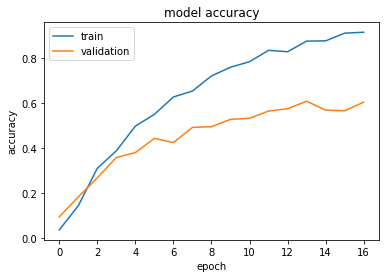

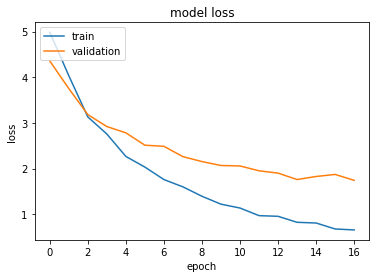

In [14]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 49s 3s/step - loss: 4.8899 - acc: 0.0418 - val_loss: 4.2427 - val_acc: 0.0977

Epoch 00001: val_acc improved from -inf to 0.09766, saving model to /data/oxford102/experiments/1549223621.7969885/densenet201_1549223621.7969885.h5
Epoch 2/100
17/17 [==============================] - 39s 2s/step - loss: 3.7907 - acc: 0.1903 - val_loss: 3.3141 - val_acc: 0.2671

Epoch 00002: val_acc improved from 0.09766 to 0.26708, saving model to /data/oxford102/experiments/1549223621.7969885/densenet201_1549223621.7969885.h5
Epoch 3/100
17/17 [==============================] - 42s 2s/step - loss: 2.6325 - acc: 0.4229 - val_loss: 2.8505 - val_acc: 0.3934

Epoch 00003: val_acc improved from 0.26708 to 0.39337, saving model to /data/oxford102/experiments/1549223621.7969885/densenet201_1549223621.7969885.h5
Epoch 4/100
17/17 [==============================] - 35s 2s/ste

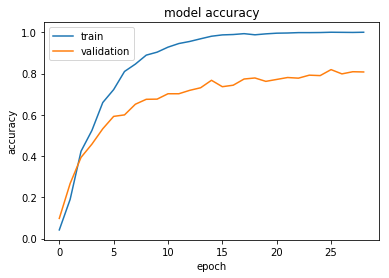

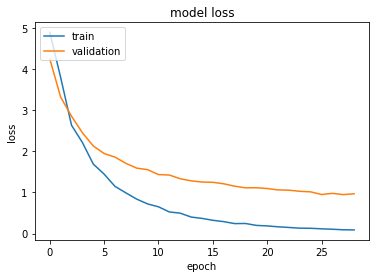

In [10]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 114s 7s/step - loss: 4.3273 - acc: 0.1209 - val_loss: 3.4400 - val_acc: 0.2510

Epoch 00001: val_acc improved from -inf to 0.25098, saving model to /data/oxford102/experiments/1549225108.8054094/nasnet_1549225108.8054094.h5
Epoch 2/100
17/17 [==============================] - 101s 6s/step - loss: 3.1268 - acc: 0.2849 - val_loss: 2.7737 - val_acc: 0.3820

Epoch 00002: val_acc improved from 0.25098 to 0.38199, saving model to /data/oxford102/experiments/1549225108.8054094/nasnet_1549225108.8054094.h5
Epoch 3/100
17/17 [==============================] - 102s 6s/step - loss: 1.9575 - acc: 0.5619 - val_loss: 2.4561 - val_acc: 0.4513

Epoch 00003: val_acc improved from 0.38199 to 0.45135, saving model to /data/oxford102/experiments/1549225108.8054094/nasnet_1549225108.8054094.h5
Epoch 4/100
17/17 [==============================] - 99s 6s/step - loss: 1.

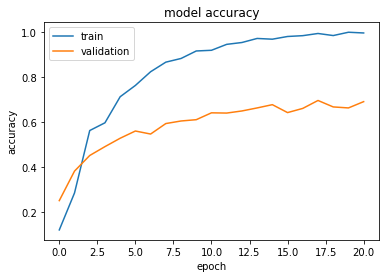

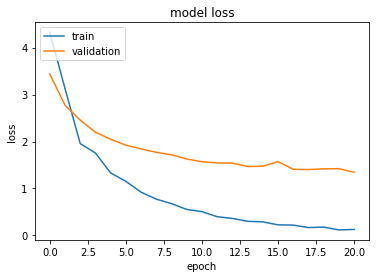

In [11]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "adadelta", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adadelta(lr=0.01, rho=0.95, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Adam

In [12]:
params = {'network_name': "mobilenet_v2",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [14]:
lr, epsilon, decay = (0.01, None, 0.0)
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 17s 1s/step - loss: 2.6224 - acc: 0.4320 - val_loss: 1.7292 - val_acc: 0.5801

Epoch 00001: val_acc improved from -inf to 0.58008, saving model to /data/oxford102/experiments/1546273533.410461/mobilenet_v2_1546273533.410461.h5
Epoch 2/100
17/17 [==============================] - 9s 532ms/step - loss: 1.3963 - acc: 0.6618 - val_loss: 1.1977 - val_acc: 0.7101

Epoch 00002: val_acc improved from 0.58008 to 0.71014, saving model to /data/oxford102/experiments/1546273533.410461/mobilenet_v2_1546273533.410461.h5
Epoch 3/100
17/17 [==============================] - 11s 675ms/step - loss: 0.4968 - acc: 0.9114 - val_loss: 0.8427 - val_acc: 0.8012

Epoch 00003: val_acc improved from 0.71014 to 0.80124, saving model to /data/oxford102/experiments/1546273533.410461/mobilenet_v2_1546273533.410461.h5
Epoch 4/100
17/17 [==============================] - 14s 818m

In [15]:
lr, epsilon, decay = (0.01, None, 0.0)
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 17s 1s/step - loss: 2.6914 - acc: 0.4283 - val_loss: 1.7614 - val_acc: 0.5996

Epoch 00001: val_acc improved from -inf to 0.59961, saving model to /data/oxford102/experiments/1546273756.7015753/mobilenet_v2_1546273756.7015753.h5
Epoch 2/100
17/17 [==============================] - 9s 543ms/step - loss: 1.4666 - acc: 0.6636 - val_loss: 1.2041 - val_acc: 0.7019

Epoch 00002: val_acc improved from 0.59961 to 0.70186, saving model to /data/oxford102/experiments/1546273756.7015753/mobilenet_v2_1546273756.7015753.h5
Epoch 3/100
17/17 [==============================] - 12s 700ms/step - loss: 0.5202 - acc: 0.9054 - val_loss: 0.9071 - val_acc: 0.7774

Epoch 00003: val_acc improved from 0.70186 to 0.77743, saving model to /data/oxford102/experiments/1546273756.7015753/mobilenet_v2_1546273756.7015753.h5
Epoch 4/100
17/17 [==============================] - 14

In [16]:
params['network_name'] = "inception_resnet_v2"
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 44s 3s/step - loss: 3.5302 - acc: 0.2385 - val_loss: 2.8001 - val_acc: 0.3574

Epoch 00001: val_acc improved from -inf to 0.35742, saving model to /data/oxford102/experiments/1546274113.3287373/inception_resnet_v2_1546274113.3287373.h5
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 2.5906 - acc: 0.3842 - val_loss: 2.1746 - val_acc: 0.4586

Epoch 00002: val_acc improved from 0.35742 to 0.45859, saving model to /data/oxford102/experiments/1546274113.3287373/inception_resnet_v2_1546274113.3287373.h5
Epoch 3/100
17/17 [==============================] - 38s 2s/step - loss: 1.6877 - acc: 0.5794 - val_loss: 1.8934 - val_acc: 0.5207

Epoch 00003: val_acc improved from 0.45859 to 0.52070, saving model to /data/oxford102/experiments/1546274113.3287373/inception_resnet_v2_1546274113.3287373.h5
Epoch 4/100
17/17 [====================

In [17]:
params['network_name'] = "inception_resnet_v2"
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 42s 2s/step - loss: 3.5376 - acc: 0.2477 - val_loss: 2.8197 - val_acc: 0.3516

Epoch 00001: val_acc improved from -inf to 0.35156, saving model to /data/oxford102/experiments/1546274823.916643/inception_resnet_v2_1546274823.916643.h5
Epoch 2/100
17/17 [==============================] - 35s 2s/step - loss: 2.5366 - acc: 0.3929 - val_loss: 2.1517 - val_acc: 0.4710

Epoch 00002: val_acc improved from 0.35156 to 0.47101, saving model to /data/oxford102/experiments/1546274823.916643/inception_resnet_v2_1546274823.916643.h5
Epoch 3/100
17/17 [==============================] - 35s 2s/step - loss: 1.6405 - acc: 0.5947 - val_loss: 1.9239 - val_acc: 0.5145

Epoch 00003: val_acc improved from 0.47101 to 0.51449, saving model to /data/oxford102/experiments/1546274823.916643/inception_resnet_v2_1546274823.916643.h5
Epoch 4/100
17/17 [==========================

In [13]:
params['network_name'] = "vgg16"
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 43s 3s/step - loss: 2.7948 - acc: 0.4076 - val_loss: 1.7120 - val_acc: 0.6221

Epoch 00001: val_acc improved from -inf to 0.62207, saving model to /data/oxford102/experiments/1546298852.16209/vgg16_1546298852.16209.h5
Epoch 2/100
17/17 [==============================] - 34s 2s/step - loss: 1.3107 - acc: 0.6962 - val_loss: 1.1244 - val_acc: 0.7474

Epoch 00002: val_acc improved from 0.62207 to 0.74741, saving model to /data/oxford102/experiments/1546298852.16209/vgg16_1546298852.16209.h5
Epoch 3/100
17/17 [==============================] - 37s 2s/step - loss: 0.3539 - acc: 0.9445 - val_loss: 0.8764 - val_acc: 0.7826

Epoch 00003: val_acc improved from 0.74741 to 0.78261, saving model to /data/oxford102/experiments/1546298852.16209/vgg16_1546298852.16209.h5
Epoch 4/100
17/17 [==============================] - 29s 2s/step - loss: 0.1763 - acc: 0.9821

In [14]:
params['network_name'] = "vgg16"
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 30s 2s/step - loss: 2.7452 - acc: 0.4154 - val_loss: 1.6841 - val_acc: 0.6230

Epoch 00001: val_acc improved from -inf to 0.62305, saving model to /data/oxford102/experiments/1546299287.931627/vgg16_1546299287.931627.h5
Epoch 2/100
17/17 [==============================] - 28s 2s/step - loss: 1.3798 - acc: 0.6746 - val_loss: 1.1194 - val_acc: 0.7329

Epoch 00002: val_acc improved from 0.62305 to 0.73292, saving model to /data/oxford102/experiments/1546299287.931627/vgg16_1546299287.931627.h5
Epoch 3/100
17/17 [==============================] - 28s 2s/step - loss: 0.3595 - acc: 0.9436 - val_loss: 0.9463 - val_acc: 0.7640

Epoch 00003: val_acc improved from 0.73292 to 0.76398, saving model to /data/oxford102/experiments/1546299287.931627/vgg16_1546299287.931627.h5
Epoch 4/100
17/17 [==============================] - 28s 2s/step - loss: 0.1838 - acc: 

In [15]:
params['network_name'] = "vgg19"
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 35s 2s/step - loss: 2.7727 - acc: 0.4072 - val_loss: 1.7249 - val_acc: 0.6035

Epoch 00001: val_acc improved from -inf to 0.60352, saving model to /data/oxford102/experiments/1546299847.9743216/vgg19_1546299847.9743216.h5
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 1.4036 - acc: 0.6682 - val_loss: 1.1962 - val_acc: 0.7081

Epoch 00002: val_acc improved from 0.60352 to 0.70807, saving model to /data/oxford102/experiments/1546299847.9743216/vgg19_1546299847.9743216.h5
Epoch 3/100
17/17 [==============================] - 33s 2s/step - loss: 0.4030 - acc: 0.9390 - val_loss: 0.9127 - val_acc: 0.7764

Epoch 00003: val_acc improved from 0.70807 to 0.77640, saving model to /data/oxford102/experiments/1546299847.9743216/vgg19_1546299847.9743216.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/step - loss: 0.2074 -

In [16]:
params['network_name'] = "vgg19"
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 35s 2s/step - loss: 2.8277 - acc: 0.4007 - val_loss: 1.7348 - val_acc: 0.5986

Epoch 00001: val_acc improved from -inf to 0.59863, saving model to /data/oxford102/experiments/1546300275.2957659/vgg19_1546300275.2957659.h5
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 1.4453 - acc: 0.6664 - val_loss: 1.1902 - val_acc: 0.7288

Epoch 00002: val_acc improved from 0.59863 to 0.72878, saving model to /data/oxford102/experiments/1546300275.2957659/vgg19_1546300275.2957659.h5
Epoch 3/100
17/17 [==============================] - 33s 2s/step - loss: 0.4226 - acc: 0.9343 - val_loss: 0.9620 - val_acc: 0.7754

Epoch 00003: val_acc improved from 0.72878 to 0.77536, saving model to /data/oxford102/experiments/1546300275.2957659/vgg19_1546300275.2957659.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/step - loss: 0.2207 -

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 22s 1s/step - loss: 2.6041 - acc: 0.4421 - val_loss: 1.6564 - val_acc: 0.6338

Epoch 00001: val_acc improved from -inf to 0.63379, saving model to /data/oxford102/experiments/1549228226.486134/mobilenet_1549228226.486134.h5
Epoch 2/100
17/17 [==============================] - 9s 519ms/step - loss: 1.2857 - acc: 0.7114 - val_loss: 0.9779 - val_acc: 0.7795

Epoch 00002: val_acc improved from 0.63379 to 0.77950, saving model to /data/oxford102/experiments/1549228226.486134/mobilenet_1549228226.486134.h5
Epoch 3/100
17/17 [==============================] - 12s 693ms/step - loss: 0.3579 - acc: 0.9523 - val_loss: 0.7202 - val_acc: 0.8385

Epoch 00003: val_acc improved from 0.77950 to 0.83851, saving model to /data/oxford102/experiments/1549228226.486134/mobilenet_1549228226.486134.h5
Epoch 4/100
17/17 [==============================] - 13s 763ms/step - 

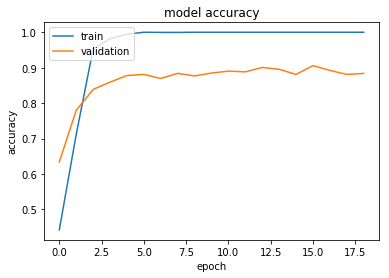

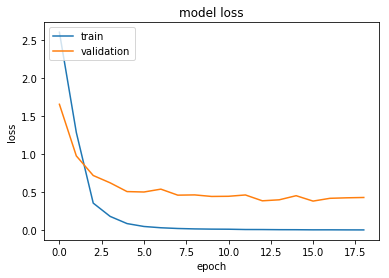

In [12]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 42s 2s/step - loss: 3.3990 - acc: 0.2739 - val_loss: 2.6239 - val_acc: 0.3867

Epoch 00001: val_acc improved from -inf to 0.38672, saving model to /data/oxford102/experiments/1549230093.432087/xception_1549230093.432087.h5
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 2.3464 - acc: 0.4472 - val_loss: 1.9521 - val_acc: 0.5145

Epoch 00002: val_acc improved from 0.38672 to 0.51449, saving model to /data/oxford102/experiments/1549230093.432087/xception_1549230093.432087.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 1.3706 - acc: 0.6761 - val_loss: 1.5587 - val_acc: 0.6222

Epoch 00003: val_acc improved from 0.51449 to 0.62215, saving model to /data/oxford102/experiments/1549230093.432087/xception_1549230093.432087.h5
Epoch 4/100
17/17 [==============================] - 35s 2s/step - loss: 1.085

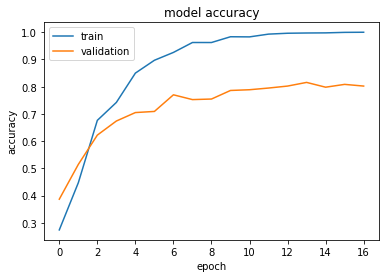

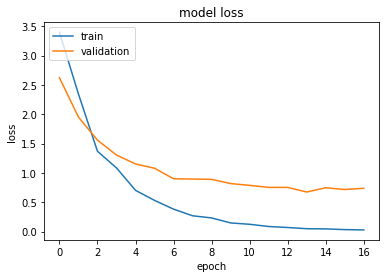

In [10]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 30s 2s/step - loss: 2.5518 - acc: 0.4619 - val_loss: 1.5855 - val_acc: 0.6465

Epoch 00001: val_acc improved from -inf to 0.64648, saving model to /data/oxford102/experiments/1549230936.433109/resnet50_1549230936.433109.h5
Epoch 2/100
17/17 [==============================] - 26s 2s/step - loss: 1.2144 - acc: 0.7100 - val_loss: 1.0170 - val_acc: 0.7484

Epoch 00002: val_acc improved from 0.64648 to 0.74845, saving model to /data/oxford102/experiments/1549230936.433109/resnet50_1549230936.433109.h5
Epoch 3/100
17/17 [==============================] - 27s 2s/step - loss: 0.3366 - acc: 0.9454 - val_loss: 0.7815 - val_acc: 0.8085

Epoch 00003: val_acc improved from 0.74845 to 0.80849, saving model to /data/oxford102/experiments/1549230936.433109/resnet50_1549230936.433109.h5
Epoch 4/100
17/17 [==============================] - 24s 1s/step - loss: 0.185

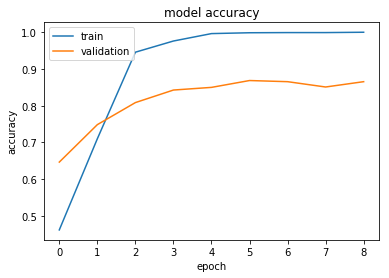

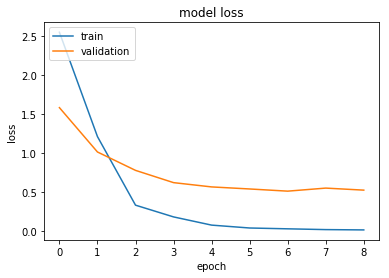

In [11]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 23s 1s/step - loss: 3.3917 - acc: 0.2822 - val_loss: 2.6437 - val_acc: 0.3818

Epoch 00001: val_acc improved from -inf to 0.38184, saving model to /data/oxford102/experiments/1549231298.9626005/inception_v3_1549231298.9626005.h5
Epoch 2/100
17/17 [==============================] - 18s 1s/step - loss: 2.3006 - acc: 0.4596 - val_loss: 1.9050 - val_acc: 0.5466

Epoch 00002: val_acc improved from 0.38184 to 0.54658, saving model to /data/oxford102/experiments/1549231298.9626005/inception_v3_1549231298.9626005.h5
Epoch 3/100
17/17 [==============================] - 19s 1s/step - loss: 1.3062 - acc: 0.7110 - val_loss: 1.5625 - val_acc: 0.5994

Epoch 00003: val_acc improved from 0.54658 to 0.59938, saving model to /data/oxford102/experiments/1549231298.9626005/inception_v3_1549231298.9626005.h5
Epoch 4/100
17/17 [==============================] - 16s 955

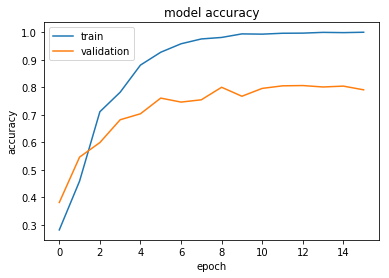

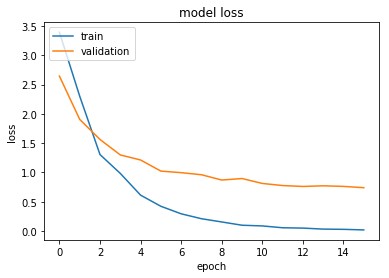

In [12]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 47s 3s/step - loss: 2.8176 - acc: 0.4067 - val_loss: 1.8813 - val_acc: 0.6025

Epoch 00001: val_acc improved from -inf to 0.60254, saving model to /data/oxford102/experiments/1549231745.266355/densenet201_1549231745.266355.h5
Epoch 2/100
17/17 [==============================] - 38s 2s/step - loss: 1.4700 - acc: 0.6769 - val_loss: 1.1583 - val_acc: 0.7547

Epoch 00002: val_acc improved from 0.60254 to 0.75466, saving model to /data/oxford102/experiments/1549231745.266355/densenet201_1549231745.266355.h5
Epoch 3/100
17/17 [==============================] - 41s 2s/step - loss: 0.5807 - acc: 0.9095 - val_loss: 0.8167 - val_acc: 0.8344

Epoch 00003: val_acc improved from 0.75466 to 0.83437, saving model to /data/oxford102/experiments/1549231745.266355/densenet201_1549231745.266355.h5
Epoch 4/100
17/17 [==============================] - 35s 2s/step - lo

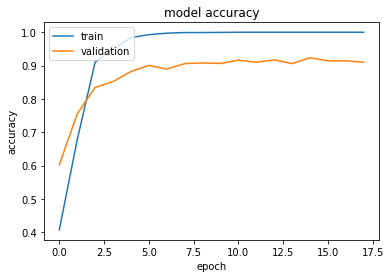

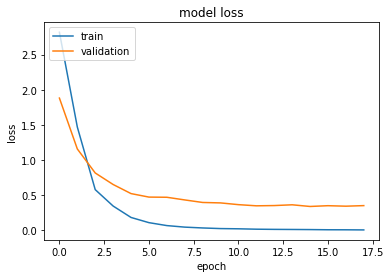

In [13]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 114s 7s/step - loss: 3.2839 - acc: 0.3065 - val_loss: 2.5484 - val_acc: 0.4004

Epoch 00001: val_acc improved from -inf to 0.40039, saving model to /data/oxford102/experiments/1549234671.2033777/nasnet_1549234671.2033777.h5
Epoch 2/100
17/17 [==============================] - 100s 6s/step - loss: 2.2882 - acc: 0.4508 - val_loss: 1.9761 - val_acc: 0.4969

Epoch 00002: val_acc improved from 0.40039 to 0.49689, saving model to /data/oxford102/experiments/1549234671.2033777/nasnet_1549234671.2033777.h5
Epoch 3/100
17/17 [==============================] - 102s 6s/step - loss: 1.1979 - acc: 0.7106 - val_loss: 1.6607 - val_acc: 0.5797

Epoch 00003: val_acc improved from 0.49689 to 0.57971, saving model to /data/oxford102/experiments/1549234671.2033777/nasnet_1549234671.2033777.h5
Epoch 4/100
17/17 [==============================] - 99s 6s/step - loss: 0.

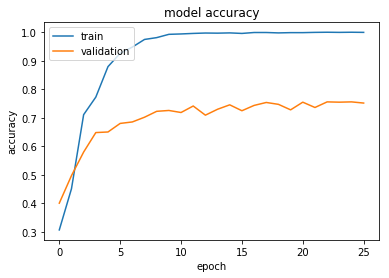

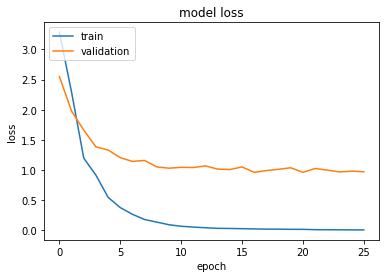

In [10]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [ ]:
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])

In [ ]:
1549231745.266355

# Adamax

In [16]:
params = {'network_name': "mobilenet_v2",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [18]:
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 18s 1s/step - loss: 2.7944 - acc: 0.3966 - val_loss: 1.8988 - val_acc: 0.5664

Epoch 00001: val_acc improved from -inf to 0.56641, saving model to /data/oxford102/experiments/1546300754.773972/mobilenet_v2_1546300754.773972.h5
Epoch 2/100
17/17 [==============================] - 10s 575ms/step - loss: 1.5841 - acc: 0.6383 - val_loss: 1.3153 - val_acc: 0.6998

Epoch 00002: val_acc improved from 0.56641 to 0.69979, saving model to /data/oxford102/experiments/1546300754.773972/mobilenet_v2_1546300754.773972.h5
Epoch 3/100
17/17 [==============================] - 13s 738ms/step - loss: 0.6337 - acc: 0.8796 - val_loss: 1.0164 - val_acc: 0.7536

Epoch 00003: val_acc improved from 0.69979 to 0.75362, saving model to /data/oxford102/experiments/1546300754.773972/mobilenet_v2_1546300754.773972.h5
Epoch 4/100
17/17 [==============================] - 14s 810

In [19]:
params['network_name'] = "inception_resnet_v2"
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 48s 3s/step - loss: 3.5963 - acc: 0.2348 - val_loss: 2.9234 - val_acc: 0.3076

Epoch 00001: val_acc improved from -inf to 0.30762, saving model to /data/oxford102/experiments/1546301159.451696/inception_resnet_v2_1546301159.451696.h5
Epoch 2/100
17/17 [==============================] - 38s 2s/step - loss: 2.6572 - acc: 0.3658 - val_loss: 2.4095 - val_acc: 0.4068

Epoch 00002: val_acc improved from 0.30762 to 0.40683, saving model to /data/oxford102/experiments/1546301159.451696/inception_resnet_v2_1546301159.451696.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 1.8428 - acc: 0.5477 - val_loss: 1.9924 - val_acc: 0.4907

Epoch 00003: val_acc improved from 0.40683 to 0.49068, saving model to /data/oxford102/experiments/1546301159.451696/inception_resnet_v2_1546301159.451696.h5
Epoch 4/100
17/17 [==========================

In [20]:
params['network_name'] = "vgg16"
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 33s 2s/step - loss: 2.8074 - acc: 0.4141 - val_loss: 1.8225 - val_acc: 0.5947

Epoch 00001: val_acc improved from -inf to 0.59473, saving model to /data/oxford102/experiments/1546302091.8038983/vgg16_1546302091.8038983.h5
Epoch 2/100
17/17 [==============================] - 29s 2s/step - loss: 1.4943 - acc: 0.6604 - val_loss: 1.2412 - val_acc: 0.7019

Epoch 00002: val_acc improved from 0.59473 to 0.70186, saving model to /data/oxford102/experiments/1546302091.8038983/vgg16_1546302091.8038983.h5
Epoch 3/100
17/17 [==============================] - 28s 2s/step - loss: 0.4918 - acc: 0.9237 - val_loss: 1.0589 - val_acc: 0.7557

Epoch 00003: val_acc improved from 0.70186 to 0.75569, saving model to /data/oxford102/experiments/1546302091.8038983/vgg16_1546302091.8038983.h5
Epoch 4/100
17/17 [==============================] - 29s 2s/step - loss: 0.2926 -

In [17]:
params['network_name'] = "vgg19"
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 45s 3s/step - loss: 2.7548 - acc: 0.4260 - val_loss: 1.8550 - val_acc: 0.5742

Epoch 00001: val_acc improved from -inf to 0.57422, saving model to /data/oxford102/experiments/1546302688.0139732/vgg19_1546302688.0139732.h5
Epoch 2/100
17/17 [==============================] - 39s 2s/step - loss: 1.4960 - acc: 0.6544 - val_loss: 1.2639 - val_acc: 0.7153

Epoch 00002: val_acc improved from 0.57422 to 0.71532, saving model to /data/oxford102/experiments/1546302688.0139732/vgg19_1546302688.0139732.h5
Epoch 3/100
17/17 [==============================] - 42s 2s/step - loss: 0.5176 - acc: 0.9182 - val_loss: 1.0592 - val_acc: 0.7526

Epoch 00003: val_acc improved from 0.71532 to 0.75259, saving model to /data/oxford102/experiments/1546302688.0139732/vgg19_1546302688.0139732.h5
Epoch 4/100
17/17 [==============================] - 34s 2s/step - loss: 0.3027 -

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 17s 993ms/step - loss: 2.6703 - acc: 0.4352 - val_loss: 1.7144 - val_acc: 0.6143

Epoch 00001: val_acc improved from -inf to 0.61426, saving model to /data/oxford102/experiments/1549239515.5665212/mobilenet_1549239515.5665212.h5
Epoch 2/100
17/17 [==============================] - 9s 502ms/step - loss: 1.3564 - acc: 0.6999 - val_loss: 1.0881 - val_acc: 0.7588

Epoch 00002: val_acc improved from 0.61426 to 0.75880, saving model to /data/oxford102/experiments/1549239515.5665212/mobilenet_1549239515.5665212.h5
Epoch 3/100
17/17 [==============================] - 12s 680ms/step - loss: 0.4476 - acc: 0.9385 - val_loss: 0.8069 - val_acc: 0.8313

Epoch 00003: val_acc improved from 0.75880 to 0.83126, saving model to /data/oxford102/experiments/1549239515.5665212/mobilenet_1549239515.5665212.h5
Epoch 4/100
17/17 [==============================] - 13s 740m

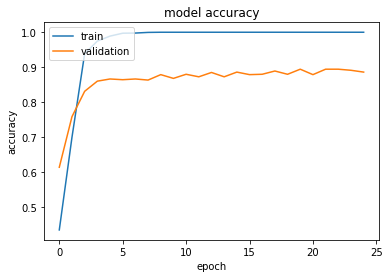

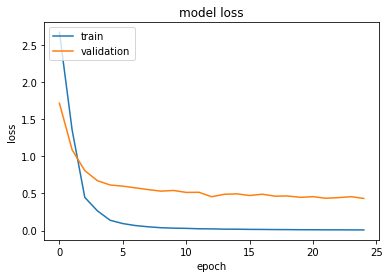

In [12]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 41s 2s/step - loss: 3.4362 - acc: 0.2753 - val_loss: 2.7153 - val_acc: 0.3652

Epoch 00001: val_acc improved from -inf to 0.36523, saving model to /data/oxford102/experiments/1549241620.460813/xception_1549241620.460813.h5
Epoch 2/100
17/17 [==============================] - 36s 2s/step - loss: 2.4794 - acc: 0.4191 - val_loss: 2.1321 - val_acc: 0.4824

Epoch 00002: val_acc improved from 0.36523 to 0.48240, saving model to /data/oxford102/experiments/1549241620.460813/xception_1549241620.460813.h5
Epoch 3/100
17/17 [==============================] - 38s 2s/step - loss: 1.5611 - acc: 0.6222 - val_loss: 1.7903 - val_acc: 0.5600

Epoch 00003: val_acc improved from 0.48240 to 0.56004, saving model to /data/oxford102/experiments/1549241620.460813/xception_1549241620.460813.h5
Epoch 4/100
17/17 [==============================] - 34s 2s/step - loss: 1.281

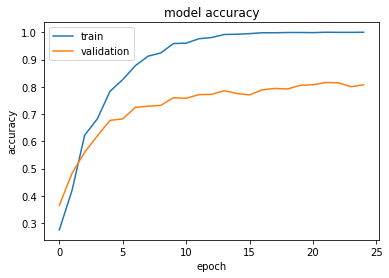

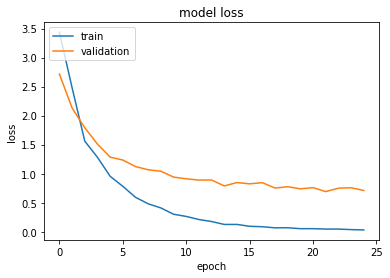

In [10]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 30s 2s/step - loss: 2.6380 - acc: 0.4435 - val_loss: 1.6967 - val_acc: 0.6289

Epoch 00001: val_acc improved from -inf to 0.62891, saving model to /data/oxford102/experiments/1549242768.6925952/resnet50_1549242768.6925952.h5
Epoch 2/100
17/17 [==============================] - 26s 2s/step - loss: 1.3937 - acc: 0.6820 - val_loss: 1.1358 - val_acc: 0.7484

Epoch 00002: val_acc improved from 0.62891 to 0.74845, saving model to /data/oxford102/experiments/1549242768.6925952/resnet50_1549242768.6925952.h5
Epoch 3/100
17/17 [==============================] - 26s 2s/step - loss: 0.4658 - acc: 0.9210 - val_loss: 0.9264 - val_acc: 0.7723

Epoch 00003: val_acc improved from 0.74845 to 0.77226, saving model to /data/oxford102/experiments/1549242768.6925952/resnet50_1549242768.6925952.h5
Epoch 4/100
17/17 [==============================] - 24s 1s/step - loss:

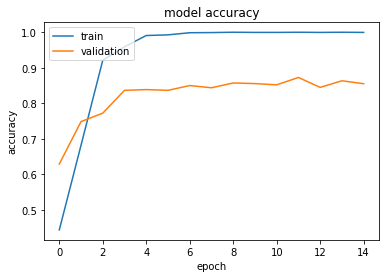

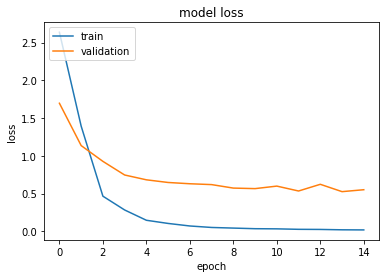

In [11]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 23s 1s/step - loss: 3.5046 - acc: 0.2633 - val_loss: 2.8001 - val_acc: 0.3516

Epoch 00001: val_acc improved from -inf to 0.35156, saving model to /data/oxford102/experiments/1549243274.8242383/inception_v3_1549243274.8242383.h5
Epoch 2/100
17/17 [==============================] - 18s 1s/step - loss: 2.4816 - acc: 0.4306 - val_loss: 2.1517 - val_acc: 0.4917

Epoch 00002: val_acc improved from 0.35156 to 0.49172, saving model to /data/oxford102/experiments/1549243274.8242383/inception_v3_1549243274.8242383.h5
Epoch 3/100
17/17 [==============================] - 19s 1s/step - loss: 1.5913 - acc: 0.6434 - val_loss: 1.6851 - val_acc: 0.5890

Epoch 00003: val_acc improved from 0.49172 to 0.58903, saving model to /data/oxford102/experiments/1549243274.8242383/inception_v3_1549243274.8242383.h5
Epoch 4/100
17/17 [==============================] - 16s 931

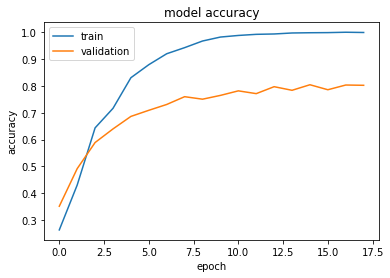

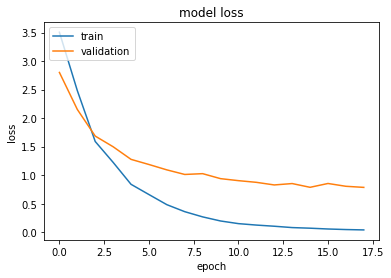

In [12]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 47s 3s/step - loss: 2.9115 - acc: 0.3943 - val_loss: 1.9717 - val_acc: 0.5811

Epoch 00001: val_acc improved from -inf to 0.58105, saving model to /data/oxford102/experiments/1549243751.4421463/densenet201_1549243751.4421463.h5
Epoch 2/100
17/17 [==============================] - 38s 2s/step - loss: 1.6202 - acc: 0.6471 - val_loss: 1.3062 - val_acc: 0.7101

Epoch 00002: val_acc improved from 0.58105 to 0.71014, saving model to /data/oxford102/experiments/1549243751.4421463/densenet201_1549243751.4421463.h5
Epoch 3/100
17/17 [==============================] - 40s 2s/step - loss: 0.7567 - acc: 0.8810 - val_loss: 0.9880 - val_acc: 0.7826

Epoch 00003: val_acc improved from 0.71014 to 0.78261, saving model to /data/oxford102/experiments/1549243751.4421463/densenet201_1549243751.4421463.h5
Epoch 4/100
17/17 [==============================] - 34s 2s/ste

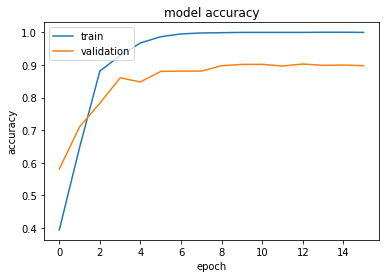

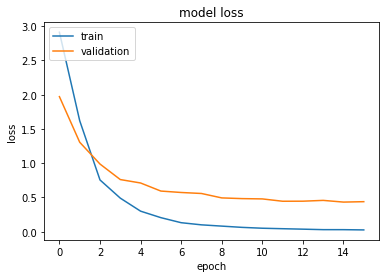

In [13]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 113s 7s/step - loss: 3.3399 - acc: 0.2840 - val_loss: 2.6104 - val_acc: 0.3945

Epoch 00001: val_acc improved from -inf to 0.39453, saving model to /data/oxford102/experiments/1549246469.8573608/nasnet_1549246469.8573608.h5
Epoch 2/100
17/17 [==============================] - 100s 6s/step - loss: 2.3734 - acc: 0.4329 - val_loss: 2.1067 - val_acc: 0.4772

Epoch 00002: val_acc improved from 0.39453 to 0.47723, saving model to /data/oxford102/experiments/1549246469.8573608/nasnet_1549246469.8573608.h5
Epoch 3/100
17/17 [==============================] - 100s 6s/step - loss: 1.3738 - acc: 0.6710 - val_loss: 1.8520 - val_acc: 0.5580

Epoch 00003: val_acc improved from 0.47723 to 0.55797, saving model to /data/oxford102/experiments/1549246469.8573608/nasnet_1549246469.8573608.h5
Epoch 4/100
17/17 [==============================] - 98s 6s/step - loss: 1.

RuntimeError: Dirty entry flush destroy failed (file write failed: time = Mon Feb  4 03:00:11 2019
, filename = '/data/oxford102/experiments/1549246469.8573608/model_nasnet_weights_final_1549246469.8573608.h5', file descriptor = 61, errno = 28, error message = 'No space left on device', buf = 0x55a6ea667600, total write size = 19512, bytes this sub-write = 19512, bytes actually written = 18446744073709551615, offset = 21245952)

# Nadam

In [16]:
params = {'network_name': "mobilenet_v2",
         'image_aug': False,
         'optimizer_name': "adam", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [19]:
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 19s 1s/step - loss: 2.5060 - acc: 0.4646 - val_loss: 1.4937 - val_acc: 0.6484

Epoch 00001: val_acc improved from -inf to 0.64844, saving model to /data/oxford102/experiments/1546303120.8429782/mobilenet_v2_1546303120.8429782.h5
Epoch 2/100
17/17 [==============================] - 10s 614ms/step - loss: 1.1118 - acc: 0.7381 - val_loss: 0.9246 - val_acc: 0.7857

Epoch 00002: val_acc improved from 0.64844 to 0.78571, saving model to /data/oxford102/experiments/1546303120.8429782/mobilenet_v2_1546303120.8429782.h5
Epoch 3/100
17/17 [==============================] - 13s 756ms/step - loss: 0.3039 - acc: 0.9482 - val_loss: 0.7225 - val_acc: 0.8178

Epoch 00003: val_acc improved from 0.78571 to 0.81781, saving model to /data/oxford102/experiments/1546303120.8429782/mobilenet_v2_1546303120.8429782.h5
Epoch 4/100
17/17 [==============================] - 1

In [20]:
params['network_name'] = "inception_resnet_v2"
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 47s 3s/step - loss: 3.2813 - acc: 0.2744 - val_loss: 2.4669 - val_acc: 0.4053

Epoch 00001: val_acc improved from -inf to 0.40527, saving model to /data/oxford102/experiments/1546303364.6238375/inception_resnet_v2_1546303364.6238375.h5
Epoch 2/100
17/17 [==============================] - 38s 2s/step - loss: 2.2292 - acc: 0.4531 - val_loss: 1.9273 - val_acc: 0.5259

Epoch 00002: val_acc improved from 0.40527 to 0.52588, saving model to /data/oxford102/experiments/1546303364.6238375/inception_resnet_v2_1546303364.6238375.h5
Epoch 3/100
17/17 [==============================] - 40s 2s/step - loss: 1.2984 - acc: 0.6917 - val_loss: 1.5588 - val_acc: 0.6242

Epoch 00003: val_acc improved from 0.52588 to 0.62422, saving model to /data/oxford102/experiments/1546303364.6238375/inception_resnet_v2_1546303364.6238375.h5
Epoch 4/100
17/17 [====================

In [21]:
params['network_name'] = "vgg16"
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 32s 2s/step - loss: 2.4716 - acc: 0.4706 - val_loss: 1.4268 - val_acc: 0.6709

Epoch 00001: val_acc improved from -inf to 0.67090, saving model to /data/oxford102/experiments/1546304347.075828/vgg16_1546304347.075828.h5
Epoch 2/100
17/17 [==============================] - 29s 2s/step - loss: 1.0991 - acc: 0.7445 - val_loss: 0.9220 - val_acc: 0.7940

Epoch 00002: val_acc improved from 0.67090 to 0.79400, saving model to /data/oxford102/experiments/1546304347.075828/vgg16_1546304347.075828.h5
Epoch 3/100
17/17 [==============================] - 29s 2s/step - loss: 0.2359 - acc: 0.9652 - val_loss: 0.8089 - val_acc: 0.8116

Epoch 00003: val_acc improved from 0.79400 to 0.81159, saving model to /data/oxford102/experiments/1546304347.075828/vgg16_1546304347.075828.h5
Epoch 4/100
17/17 [==============================] - 28s 2s/step - loss: 0.1006 - acc: 

In [22]:
params['network_name'] = "vgg19"
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 36s 2s/step - loss: 2.4515 - acc: 0.4701 - val_loss: 1.4599 - val_acc: 0.6592

Epoch 00001: val_acc improved from -inf to 0.65918, saving model to /data/oxford102/experiments/1546304767.6417031/vgg19_1546304767.6417031.h5
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 1.1295 - acc: 0.7335 - val_loss: 0.9493 - val_acc: 0.7712

Epoch 00002: val_acc improved from 0.65918 to 0.77122, saving model to /data/oxford102/experiments/1546304767.6417031/vgg19_1546304767.6417031.h5
Epoch 3/100
17/17 [==============================] - 33s 2s/step - loss: 0.2492 - acc: 0.9620 - val_loss: 0.7858 - val_acc: 0.8147

Epoch 00003: val_acc improved from 0.77122 to 0.81470, saving model to /data/oxford102/experiments/1546304767.6417031/vgg19_1546304767.6417031.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/step - loss: 0.1143 -

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 60s 4s/step - loss: 2.3562 - acc: 0.4982 - val_loss: 1.3257 - val_acc: 0.7031

Epoch 00001: val_acc improved from -inf to 0.70312, saving model to /data/oxford102/experiments/1549250759.5111377/mobilenet_1549250759.5111377.h5
Epoch 2/100
17/17 [==============================] - 9s 539ms/step - loss: 0.9706 - acc: 0.7858 - val_loss: 0.7533 - val_acc: 0.8447

Epoch 00002: val_acc improved from 0.70312 to 0.84472, saving model to /data/oxford102/experiments/1549250759.5111377/mobilenet_1549250759.5111377.h5
Epoch 3/100
17/17 [==============================] - 15s 901ms/step - loss: 0.1996 - acc: 0.9754 - val_loss: 0.5219 - val_acc: 0.8923

Epoch 00003: val_acc improved from 0.84472 to 0.89234, saving model to /data/oxford102/experiments/1549250759.5111377/mobilenet_1549250759.5111377.h5
Epoch 4/100
17/17 [==============================] - 15s 882ms/s

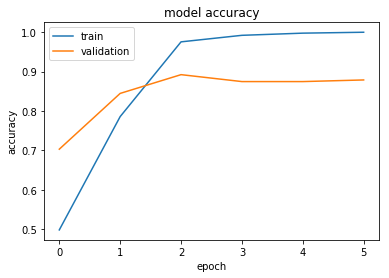

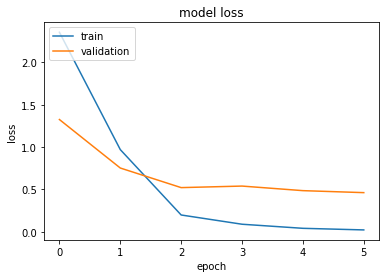

In [11]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 42s 2s/step - loss: 3.1182 - acc: 0.3217 - val_loss: 2.2304 - val_acc: 0.4502

Epoch 00001: val_acc improved from -inf to 0.45020, saving model to /data/oxford102/experiments/1549250954.6184332/xception_1549250954.6184332.h5
Epoch 2/100
17/17 [==============================] - 38s 2s/step - loss: 1.8724 - acc: 0.5450 - val_loss: 1.5364 - val_acc: 0.6180

Epoch 00002: val_acc improved from 0.45020 to 0.61801, saving model to /data/oxford102/experiments/1549250954.6184332/xception_1549250954.6184332.h5
Epoch 3/100
17/17 [==============================] - 38s 2s/step - loss: 0.9195 - acc: 0.7916 - val_loss: 1.2122 - val_acc: 0.7050

Epoch 00003: val_acc improved from 0.61801 to 0.70497, saving model to /data/oxford102/experiments/1549250954.6184332/xception_1549250954.6184332.h5
Epoch 4/100
17/17 [==============================] - 36s 2s/step - loss:

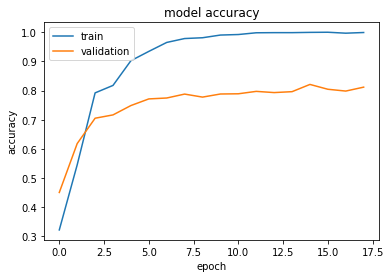

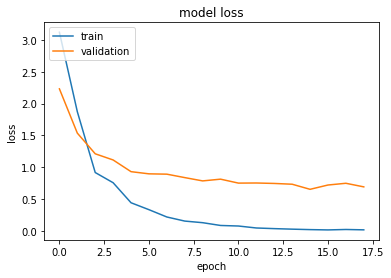

In [12]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 31s 2s/step - loss: 2.2880 - acc: 0.5184 - val_loss: 1.2214 - val_acc: 0.7041

Epoch 00001: val_acc improved from -inf to 0.70410, saving model to /data/oxford102/experiments/1549251831.1033685/resnet50_1549251831.1033685.h5
Epoch 2/100
17/17 [==============================] - 34s 2s/step - loss: 0.9270 - acc: 0.7799 - val_loss: 0.7343 - val_acc: 0.8178

Epoch 00002: val_acc improved from 0.70410 to 0.81781, saving model to /data/oxford102/experiments/1549251831.1033685/resnet50_1549251831.1033685.h5
Epoch 3/100
17/17 [==============================] - 27s 2s/step - loss: 0.1824 - acc: 0.9722 - val_loss: 0.6322 - val_acc: 0.8302

Epoch 00003: val_acc improved from 0.81781 to 0.83023, saving model to /data/oxford102/experiments/1549251831.1033685/resnet50_1549251831.1033685.h5
Epoch 4/100
17/17 [==============================] - 25s 1s/step - loss:

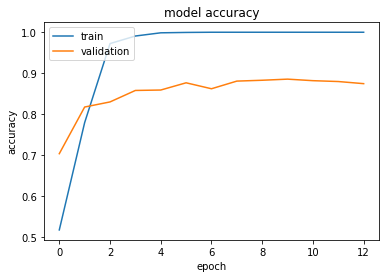

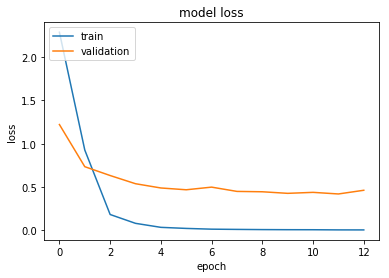

In [13]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 24s 1s/step - loss: 3.3560 - acc: 0.2803 - val_loss: 2.4115 - val_acc: 0.4404

Epoch 00001: val_acc improved from -inf to 0.44043, saving model to /data/oxford102/experiments/1549252393.4133952/inception_v3_1549252393.4133952.h5
Epoch 2/100
17/17 [==============================] - 20s 1s/step - loss: 2.0070 - acc: 0.5358 - val_loss: 1.7493 - val_acc: 0.5911

Epoch 00002: val_acc improved from 0.44043 to 0.59110, saving model to /data/oxford102/experiments/1549252393.4133952/inception_v3_1549252393.4133952.h5
Epoch 3/100
17/17 [==============================] - 19s 1s/step - loss: 1.0155 - acc: 0.7926 - val_loss: 1.2784 - val_acc: 0.6843

Epoch 00003: val_acc improved from 0.59110 to 0.68427, saving model to /data/oxford102/experiments/1549252393.4133952/inception_v3_1549252393.4133952.h5
Epoch 4/100
17/17 [==============================] - 17s 978

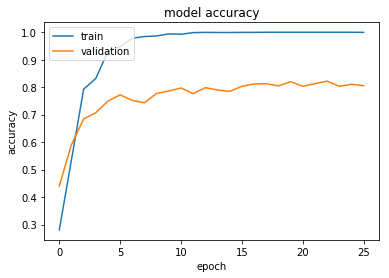

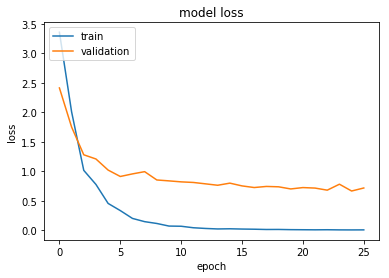

In [14]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 49s 3s/step - loss: 2.6519 - acc: 0.4577 - val_loss: 1.5679 - val_acc: 0.6748

Epoch 00001: val_acc improved from -inf to 0.67480, saving model to /data/oxford102/experiments/1549332472.65966/densenet201_1549332472.65966.h5
Epoch 2/100
17/17 [==============================] - 39s 2s/step - loss: 1.1503 - acc: 0.7656 - val_loss: 0.8936 - val_acc: 0.8199

Epoch 00002: val_acc improved from 0.67480 to 0.81988, saving model to /data/oxford102/experiments/1549332472.65966/densenet201_1549332472.65966.h5
Epoch 3/100
17/17 [==============================] - 41s 2s/step - loss: 0.3496 - acc: 0.9450 - val_loss: 0.6543 - val_acc: 0.8509

Epoch 00003: val_acc improved from 0.81988 to 0.85093, saving model to /data/oxford102/experiments/1549332472.65966/densenet201_1549332472.65966.h5
Epoch 4/100
17/17 [==============================] - 35s 2s/step - loss: 0.

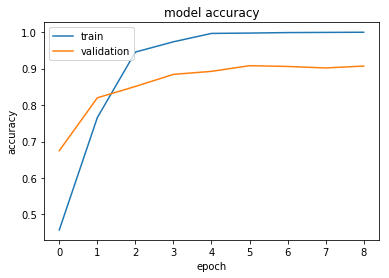

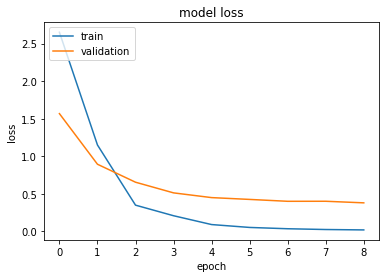

In [12]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 111s 7s/step - loss: 3.0210 - acc: 0.3341 - val_loss: 2.2912 - val_acc: 0.4424

Epoch 00001: val_acc improved from -inf to 0.44238, saving model to /data/oxford102/experiments/1549333051.6952314/nasnet_1549333051.6952314.h5
Epoch 2/100
17/17 [==============================] - 98s 6s/step - loss: 1.9182 - acc: 0.5285 - val_loss: 1.6964 - val_acc: 0.5890

Epoch 00002: val_acc improved from 0.44238 to 0.58903, saving model to /data/oxford102/experiments/1549333051.6952314/nasnet_1549333051.6952314.h5
Epoch 3/100
17/17 [==============================] - 98s 6s/step - loss: 0.7767 - acc: 0.8145 - val_loss: 1.4121 - val_acc: 0.6398

Epoch 00003: val_acc improved from 0.58903 to 0.63975, saving model to /data/oxford102/experiments/1549333051.6952314/nasnet_1549333051.6952314.h5
Epoch 4/100
17/17 [==============================] - 95s 6s/step - loss: 0.54

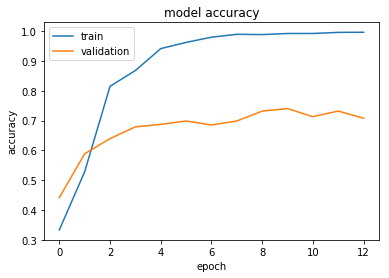

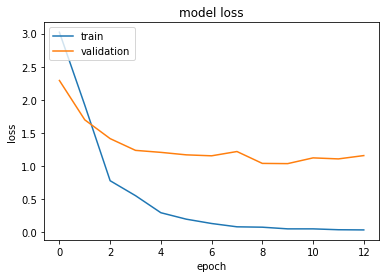

In [13]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "adammax", 
         'optimizer': None,
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}
_optimizer = optimizers.Nadam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# SGD

In [15]:
params = {'network_name': "vgg16",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

In [11]:
params['network_name'] = "vgg16"
params['optimizer_name'] = "SGD"
_optimizer = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 39s 2s/step - loss: 4.5988 - acc: 0.0767 - val_loss: 3.8980 - val_acc: 0.1631

Epoch 00001: val_acc improved from -inf to 0.16309, saving model to /data/oxford102/experiments/1546749875.1105452/vgg16_1546749875.1105452.h5
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 3.4646 - acc: 0.2408 - val_loss: 3.0891 - val_acc: 0.3188

Epoch 00002: val_acc improved from 0.16309 to 0.31884, saving model to /data/oxford102/experiments/1546749875.1105452/vgg16_1546749875.1105452.h5
Epoch 3/100
17/17 [==============================] - 37s 2s/step - loss: 2.3284 - acc: 0.4841 - val_loss: 2.7484 - val_acc: 0.3954

Epoch 00003: val_acc improved from 0.31884 to 0.39545, saving model to /data/oxford102/experiments/1546749875.1105452/vgg16_1546749875.1105452.h5
Epoch 4/100
17/17 [==============================] - 28s 2s/step - loss: 1.9892 -

In [12]:
params['network_name'] = "vgg19"
params['optimizer_name'] = "SGD"
_optimizer = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 35s 2s/step - loss: 4.5630 - acc: 0.0836 - val_loss: 3.7900 - val_acc: 0.1797

Epoch 00001: val_acc improved from -inf to 0.17969, saving model to /data/oxford102/experiments/1546750293.552338/vgg19_1546750293.552338.h5
Epoch 2/100
17/17 [==============================] - 32s 2s/step - loss: 3.4270 - acc: 0.2413 - val_loss: 3.0336 - val_acc: 0.3261

Epoch 00002: val_acc improved from 0.17969 to 0.32609, saving model to /data/oxford102/experiments/1546750293.552338/vgg19_1546750293.552338.h5
Epoch 3/100
17/17 [==============================] - 32s 2s/step - loss: 2.3005 - acc: 0.4808 - val_loss: 2.6558 - val_acc: 0.4110

Epoch 00003: val_acc improved from 0.32609 to 0.41097, saving model to /data/oxford102/experiments/1546750293.552338/vgg19_1546750293.552338.h5
Epoch 4/100
17/17 [==============================] - 32s 2s/step - loss: 1.9894 - acc: 

In [13]:
params['network_name'] = "inception_resnet_v2"
params['optimizer_name'] = "SGD"
_optimizer = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 44s 3s/step - loss: 4.1383 - acc: 0.1434 - val_loss: 3.2948 - val_acc: 0.2646

Epoch 00001: val_acc improved from -inf to 0.26465, saving model to /data/oxford102/experiments/1546751082.4979792/inception_resnet_v2_1546751082.4979792.h5
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 3.0353 - acc: 0.3125 - val_loss: 2.7439 - val_acc: 0.3696

Epoch 00002: val_acc improved from 0.26465 to 0.36957, saving model to /data/oxford102/experiments/1546751082.4979792/inception_resnet_v2_1546751082.4979792.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 2.2819 - acc: 0.4796 - val_loss: 2.4000 - val_acc: 0.4431

Epoch 00003: val_acc improved from 0.36957 to 0.44306, saving model to /data/oxford102/experiments/1546751082.4979792/inception_resnet_v2_1546751082.4979792.h5
Epoch 4/100
17/17 [====================

In [15]:
params['network_name'] = "mobilenet_v2"
params['optimizer_name'] = "SGD"
_optimizer = optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 18s 1s/step - loss: 3.7616 - acc: 0.2151 - val_loss: 2.7583 - val_acc: 0.3945

Epoch 00001: val_acc improved from -inf to 0.39453, saving model to /data/oxford102/experiments/1546753858.6357646/mobilenet_v2_1546753858.6357646.h5
Epoch 2/100
17/17 [==============================] - 9s 515ms/step - loss: 2.3164 - acc: 0.4775 - val_loss: 1.9041 - val_acc: 0.5745

Epoch 00002: val_acc improved from 0.39453 to 0.57453, saving model to /data/oxford102/experiments/1546753858.6357646/mobilenet_v2_1546753858.6357646.h5
Epoch 3/100
17/17 [==============================] - 12s 713ms/step - loss: 1.1986 - acc: 0.7585 - val_loss: 1.6312 - val_acc: 0.6335

Epoch 00003: val_acc improved from 0.57453 to 0.63354, saving model to /data/oxford102/experiments/1546753858.6357646/mobilenet_v2_1546753858.6357646.h5
Epoch 4/100
17/17 [==============================] - 13

In [16]:
params['network_name'] = "mobilenet_v2"
params['optimizer_name'] = "SGD"
_optimizer = optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 19s 1s/step - loss: 5.2747 - acc: 0.0133 - val_loss: 4.8617 - val_acc: 0.0381

Epoch 00001: val_acc improved from -inf to 0.03809, saving model to /data/oxford102/experiments/1546754274.016218/mobilenet_v2_1546754274.016218.h5
Epoch 2/100
17/17 [==============================] - 8s 482ms/step - loss: 4.7124 - acc: 0.0418 - val_loss: 4.4052 - val_acc: 0.0756

Epoch 00002: val_acc improved from 0.03809 to 0.07557, saving model to /data/oxford102/experiments/1546754274.016218/mobilenet_v2_1546754274.016218.h5
Epoch 3/100
17/17 [==============================] - 12s 732ms/step - loss: 3.9972 - acc: 0.1334 - val_loss: 4.0063 - val_acc: 0.1646

Epoch 00003: val_acc improved from 0.07557 to 0.16460, saving model to /data/oxford102/experiments/1546754274.016218/mobilenet_v2_1546754274.016218.h5
Epoch 4/100
17/17 [==============================] - 14s 836m

In [17]:
params['network_name'] = "mobilenet_v2"
params['optimizer_name'] = "SGD"
_optimizer = optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 17s 1s/step - loss: 2.7860 - acc: 0.4099 - val_loss: 1.8418 - val_acc: 0.5869

Epoch 00001: val_acc improved from -inf to 0.58691, saving model to /data/oxford102/experiments/1546754934.4831538/mobilenet_v2_1546754934.4831538.h5
Epoch 2/100
17/17 [==============================] - 8s 483ms/step - loss: 1.5499 - acc: 0.6498 - val_loss: 1.3357 - val_acc: 0.7050

Epoch 00002: val_acc improved from 0.58691 to 0.70497, saving model to /data/oxford102/experiments/1546754934.4831538/mobilenet_v2_1546754934.4831538.h5
Epoch 3/100
17/17 [==============================] - 12s 734ms/step - loss: 0.6693 - acc: 0.8930 - val_loss: 1.0429 - val_acc: 0.7578

Epoch 00003: val_acc improved from 0.70497 to 0.75776, saving model to /data/oxford102/experiments/1546754934.4831538/mobilenet_v2_1546754934.4831538.h5
Epoch 4/100
17/17 [==============================] - 13

# repeat since acc very high

In [17]:
params['network_name'] = "mobilenet_v2"
params['optimizer_name'] = "SGD"
_optimizer = optimizers.SGD(lr=0.1, momentum=0.0, decay=0.0, nesterov=False)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 18s 1s/step - loss: 2.6976 - acc: 0.4177 - val_loss: 1.7442 - val_acc: 0.6045

Epoch 00001: val_acc improved from -inf to 0.60449, saving model to /data/oxford102/experiments/1546811162.66211/mobilenet_v2_1546811162.66211.h5
Epoch 2/100
17/17 [==============================] - 8s 500ms/step - loss: 1.4425 - acc: 0.6733 - val_loss: 1.2568 - val_acc: 0.7122

Epoch 00002: val_acc improved from 0.60449 to 0.71222, saving model to /data/oxford102/experiments/1546811162.66211/mobilenet_v2_1546811162.66211.h5
Epoch 3/100
17/17 [==============================] - 13s 785ms/step - loss: 0.6218 - acc: 0.8897 - val_loss: 1.0024 - val_acc: 0.7733

Epoch 00003: val_acc improved from 0.71222 to 0.77329, saving model to /data/oxford102/experiments/1546811162.66211/mobilenet_v2_1546811162.66211.h5
Epoch 4/100
17/17 [==============================] - 13s 773ms/step

In [18]:
# RMSPROP

In [19]:
params['network_name'] = "vgg16"
params['optimizer_name'] = "RMSprop"
_optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 32s 2s/step - loss: 2.4028 - acc: 0.4936 - val_loss: 1.5220 - val_acc: 0.6611

Epoch 00001: val_acc improved from -inf to 0.66113, saving model to /data/oxford102/experiments/1546755154.390664/vgg16_1546755154.390664.h5
Epoch 2/100
17/17 [==============================] - 28s 2s/step - loss: 1.1838 - acc: 0.7376 - val_loss: 1.0485 - val_acc: 0.7598

Epoch 00002: val_acc improved from 0.66113 to 0.75983, saving model to /data/oxford102/experiments/1546755154.390664/vgg16_1546755154.390664.h5
Epoch 3/100
17/17 [==============================] - 28s 2s/step - loss: 0.2884 - acc: 0.9597 - val_loss: 0.8874 - val_acc: 0.7940

Epoch 00003: val_acc improved from 0.75983 to 0.79400, saving model to /data/oxford102/experiments/1546755154.390664/vgg16_1546755154.390664.h5
Epoch 4/100
17/17 [==============================] - 29s 2s/step - loss: 0.1429 - acc: 

In [20]:
params['network_name'] = "vgg19"
params['optimizer_name'] = "RMSprop"
_optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 36s 2s/step - loss: 2.4633 - acc: 0.4802 - val_loss: 1.5107 - val_acc: 0.6729

Epoch 00001: val_acc improved from -inf to 0.67285, saving model to /data/oxford102/experiments/1546755535.920222/vgg19_1546755535.920222.h5
Epoch 2/100
17/17 [==============================] - 33s 2s/step - loss: 1.2405 - acc: 0.7096 - val_loss: 1.0181 - val_acc: 0.7754

Epoch 00002: val_acc improved from 0.67285 to 0.77536, saving model to /data/oxford102/experiments/1546755535.920222/vgg19_1546755535.920222.h5
Epoch 3/100
17/17 [==============================] - 33s 2s/step - loss: 0.2995 - acc: 0.9565 - val_loss: 0.8805 - val_acc: 0.7909

Epoch 00003: val_acc improved from 0.77536 to 0.79089, saving model to /data/oxford102/experiments/1546755535.920222/vgg19_1546755535.920222.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/step - loss: 0.1765 - acc: 

In [21]:
params['network_name'] = "inception_resnet_v2"
params['optimizer_name'] = "RMSprop"
_optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 45s 3s/step - loss: 3.3076 - acc: 0.2707 - val_loss: 2.5562 - val_acc: 0.3975

Epoch 00001: val_acc improved from -inf to 0.39746, saving model to /data/oxford102/experiments/1546756006.1082816/inception_resnet_v2_1546756006.1082816.h5
Epoch 2/100
17/17 [==============================] - 36s 2s/step - loss: 2.3523 - acc: 0.4513 - val_loss: 2.0389 - val_acc: 0.5280

Epoch 00002: val_acc improved from 0.39746 to 0.52795, saving model to /data/oxford102/experiments/1546756006.1082816/inception_resnet_v2_1546756006.1082816.h5
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 1.5828 - acc: 0.6434 - val_loss: 1.8387 - val_acc: 0.5735

Epoch 00003: val_acc improved from 0.52795 to 0.57350, saving model to /data/oxford102/experiments/1546756006.1082816/inception_resnet_v2_1546756006.1082816.h5
Epoch 4/100
17/17 [====================

In [16]:
params['network_name'] = "mobilenet_v2"
params['optimizer_name'] = "RMSprop"
_optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
params['optimizer'] = _optimizer
_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:38: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 22s 1s/step - loss: 2.4331 - acc: 0.4752 - val_loss: 1.4218 - val_acc: 0.6689

Epoch 00001: val_acc improved from -inf to 0.66895, saving model to /data/oxford102/experiments/1546806727.064228/mobilenet_v2_1546806727.064228.h5
Epoch 2/100
17/17 [==============================] - 11s 671ms/step - loss: 1.1659 - acc: 0.7348 - val_loss: 1.0275 - val_acc: 0.7692

Epoch 00002: val_acc improved from 0.66895 to 0.76915, saving model to /data/oxford102/experiments/1546806727.064228/mobilenet_v2_1546806727.064228.h5
Epoch 3/100
17/17 [==============================] - 14s 852ms/step - loss: 0.3222 - acc: 0.9487 - val_loss: 0.8455 - val_acc: 0.8064

Epoch 00003: val_acc improved from 0.76915 to 0.80642, saving model to /data/oxford102/experiments/1546806727.064228/mobilenet_v2_1546806727.064228.h5
Epoch 4/100
17/17 [==============================] - 14s 815

###### 

In [11]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 21s 1s/step - loss: 4.1638 - acc: 0.1631 - val_loss: 3.1621 - val_acc: 0.3096

Epoch 00001: val_acc improved from -inf to 0.30957, saving model to /data/oxford102/experiments/1548634790.7813857/mobilenet_1548634790.7813857.h5
Epoch 2/100
17/17 [==============================] - 15s 889ms/step - loss: 2.6903 - acc: 0.3966 - val_loss: 2.2877 - val_acc: 0.4876

Epoch 00002: val_acc improved from 0.30957 to 0.48758, saving model to /data/oxford102/experiments/1548634790.7813857/mobilenet_1548634790.7813857.h5
Epoch 3/100
17/17 [==============================] - 15s 899ms/step - loss: 1.3885 - acc: 0.7215 - val_loss: 1.7658 - val_acc: 0.6170

Epoch 00003: val_acc improved from 0.48758 to 0.61698, saving model to /data/oxford102/experiments/1548634790.7813857/mobilenet_1548634790.7813857.h5
Epoch 4/100
17/17 [==============================] - 13s 786ms/

In [12]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

83689472/83683744 [==============================] - 1s 0us/step


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 39s 2s/step - loss: 3.4610 - acc: 0.2642 - val_loss: 2.5493 - val_acc: 0.4141

Epoch 00001: val_acc improved from -inf to 0.41406, saving model to /data/oxford102/experiments/1548635528.4724216/xception_1548635528.4724216.h5
Epoch 2/100
17/17 [==============================] - 35s 2s/step - loss: 2.2216 - acc: 0.4922 - val_loss: 1.9418 - val_acc: 0.5497

Epoch 00002: val_acc improved from 0.41406 to 0.54969, saving model to /data/oxford102/experiments/1548635528.4724216/xception_1548635528.4724216.h5
Epoch 3/100
17/17 [==============================] - 36s 2s/step - loss: 1.4388 - acc: 0.6849 - val_loss: 1.6660 - val_acc: 0.6201

Epoch 00003: val_acc improved from 0.54969 to 0.62008, saving model to /data/oxford102/experiments/1548635528.4724216/xception_1548635528.4724216.h5
Epoch 4/100
17/17 [==============================] - 32s 2s/step - loss:

In [13]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 28s 2s/step - loss: 3.5051 - acc: 0.2702 - val_loss: 2.3284 - val_acc: 0.4717

Epoch 00001: val_acc improved from -inf to 0.47168, saving model to /data/oxford102/experiments/1548636533.0114524/resnet50_1548636533.0114524.h5
Epoch 2/100
17/17 [==============================] - 24s 1s/step - loss: 1.9807 - acc: 0.5515 - val_loss: 1.6318 - val_acc: 0.6335

Epoch 00002: val_acc improved from 0.47168 to 0.63354, saving model to /data/oxford102/experiments/1548636533.0114524/resnet50_1548636533.0114524.h5
Epoch 3/100
17/17 [==============================] - 25s 1s/step - loss: 0.8672 - acc: 0.8477 - val_loss: 1.3925 - val_acc: 0.6905

Epoch 00003: val_acc improved from 0.63354 to 0.69048, saving model to /data/oxford102/experiments/1548636533.0114524/resnet50_1548636533.0114524.h5
Epoch 4/100
17/17 [==============================] - 22s 1s/step - loss:

In [14]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 22s 1s/step - loss: 4.1585 - acc: 0.1461 - val_loss: 3.2130 - val_acc: 0.2715

Epoch 00001: val_acc improved from -inf to 0.27148, saving model to /data/oxford102/experiments/1548636868.7603292/inception_v3_1548636868.7603292.h5
Epoch 2/100
17/17 [==============================] - 17s 1s/step - loss: 2.9090 - acc: 0.3392 - val_loss: 2.5033 - val_acc: 0.4224

Epoch 00002: val_acc improved from 0.27148 to 0.42236, saving model to /data/oxford102/experiments/1548636868.7603292/inception_v3_1548636868.7603292.h5
Epoch 3/100
17/17 [==============================] - 18s 1s/step - loss: 1.9164 - acc: 0.5749 - val_loss: 2.1083 - val_acc: 0.5104

Epoch 00003: val_acc improved from 0.42236 to 0.51035, saving model to /data/oxford102/experiments/1548636868.7603292/inception_v3_1548636868.7603292.h5
Epoch 4/100
17/17 [==============================] - 15s 900

In [15]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 44s 3s/step - loss: 3.3305 - acc: 0.3019 - val_loss: 2.2128 - val_acc: 0.5078

Epoch 00001: val_acc improved from -inf to 0.50781, saving model to /data/oxford102/experiments/1548637322.6959262/densenet201_1548637322.6959262.h5
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 1.9007 - acc: 0.5928 - val_loss: 1.5311 - val_acc: 0.6832

Epoch 00002: val_acc improved from 0.50781 to 0.68323, saving model to /data/oxford102/experiments/1548637322.6959262/densenet201_1548637322.6959262.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 0.9796 - acc: 0.8286 - val_loss: 1.2913 - val_acc: 0.7329

Epoch 00003: val_acc improved from 0.68323 to 0.73292, saving model to /data/oxford102/experiments/1548637322.6959262/densenet201_1548637322.6959262.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/ste

In [11]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 46s 3s/step - loss: 3.3196 - acc: 0.3019 - val_loss: 2.3702 - val_acc: 0.5010

Epoch 00001: val_acc improved from -inf to 0.50098, saving model to /data/oxford102/experiments/1548640373.6929662/densenet201_1548640373.6929662.h5
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 1.8928 - acc: 0.5901 - val_loss: 1.5392 - val_acc: 0.6770

Epoch 00002: val_acc improved from 0.50098 to 0.67702, saving model to /data/oxford102/experiments/1548640373.6929662/densenet201_1548640373.6929662.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 0.9896 - acc: 0.8358 - val_loss: 1.3099 - val_acc: 0.7329

Epoch 00003: val_acc improved from 0.67702 to 0.73292, saving model to /data/oxford102/experiments/1548640373.6929662/densenet201_1548640373.6929662.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/ste

In [12]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 105s 6s/step - loss: 3.3668 - acc: 0.2656 - val_loss: 2.5223 - val_acc: 0.3975

Epoch 00001: val_acc improved from -inf to 0.39746, saving model to /data/oxford102/experiments/1548641320.3534381/nasnet_1548641320.3534381.h5
Epoch 2/100
17/17 [==============================] - 94s 6s/step - loss: 2.2312 - acc: 0.4766 - val_loss: 2.0164 - val_acc: 0.5083

Epoch 00002: val_acc improved from 0.39746 to 0.50828, saving model to /data/oxford102/experiments/1548641320.3534381/nasnet_1548641320.3534381.h5
Epoch 3/100
17/17 [==============================] - 95s 6s/step - loss: 1.3298 - acc: 0.6908 - val_loss: 1.7816 - val_acc: 0.5704

Epoch 00003: val_acc improved from 0.50828 to 0.57039, saving model to /data/oxford102/experiments/1548641320.3534381/nasnet_1548641320.3534381.h5
Epoch 4/100
17/17 [==============================] - 93s 5s/step - loss: 1.13

In [18]:
params = {'network_name': "mobilenet",
         'image_aug': False,
         'optimizer_name': "RMSprop", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 18s 1s/step - loss: 2.3356 - acc: 0.5244 - val_loss: 1.3223 - val_acc: 0.7266

Epoch 00001: val_acc improved from -inf to 0.72656, saving model to /data/oxford102/experiments/1548645681.0791426/mobilenet_1548645681.0791426.h5
Epoch 2/100
17/17 [==============================] - 8s 492ms/step - loss: 1.0571 - acc: 0.7799 - val_loss: 0.8391 - val_acc: 0.8458

Epoch 00002: val_acc improved from 0.72656 to 0.84576, saving model to /data/oxford102/experiments/1548645681.0791426/mobilenet_1548645681.0791426.h5
Epoch 3/100
17/17 [==============================] - 14s 805ms/step - loss: 0.2272 - acc: 0.9740 - val_loss: 0.6532 - val_acc: 0.8520

Epoch 00003: val_acc improved from 0.84576 to 0.85197, saving model to /data/oxford102/experiments/1548645681.0791426/mobilenet_1548645681.0791426.h5
Epoch 4/100
17/17 [==============================] - 13s 787ms/s

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


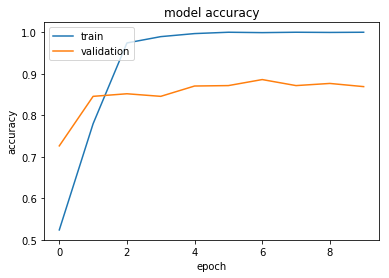

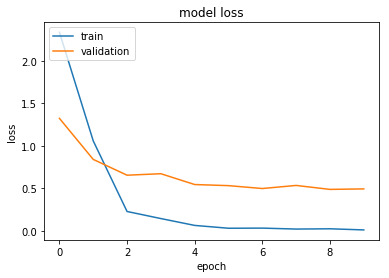

In [20]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
params = {'network_name': "xception",
         'image_aug': False,
         'optimizer_name': "RMSprop", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 40s 2s/step - loss: 3.0892 - acc: 0.3369 - val_loss: 2.1805 - val_acc: 0.4922

Epoch 00001: val_acc improved from -inf to 0.49219, saving model to /data/oxford102/experiments/1548646984.5059414/xception_1548646984.5059414.h5
Epoch 2/100
17/17 [==============================] - 35s 2s/step - loss: 1.8706 - acc: 0.5708 - val_loss: 1.5920 - val_acc: 0.6460

Epoch 00002: val_acc improved from 0.49219 to 0.64596, saving model to /data/oxford102/experiments/1548646984.5059414/xception_1548646984.5059414.h5
Epoch 3/100
17/17 [==============================] - 37s 2s/step - loss: 1.0133 - acc: 0.7959 - val_loss: 1.3574 - val_acc: 0.6729

Epoch 00003: val_acc improved from 0.64596 to 0.67288, saving model to /data/oxford102/experiments/1548646984.5059414/xception_1548646984.5059414.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/step - loss:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


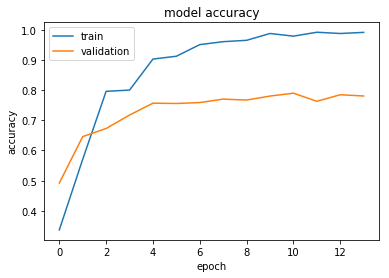

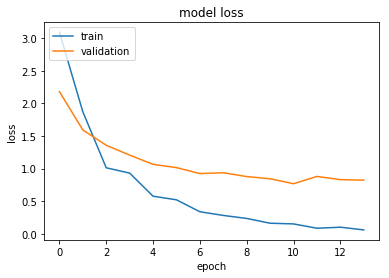

In [11]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
params = {'network_name': "resnet50",
         'image_aug': False,
         'optimizer_name': "RMSprop", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 29s 2s/step - loss: 2.2291 - acc: 0.5234 - val_loss: 1.2127 - val_acc: 0.7314

Epoch 00001: val_acc improved from -inf to 0.73145, saving model to /data/oxford102/experiments/1548647565.9059446/resnet50_1548647565.9059446.h5
Epoch 2/100
17/17 [==============================] - 25s 1s/step - loss: 0.9444 - acc: 0.7895 - val_loss: 0.8122 - val_acc: 0.8240

Epoch 00002: val_acc improved from 0.73145 to 0.82402, saving model to /data/oxford102/experiments/1548647565.9059446/resnet50_1548647565.9059446.h5
Epoch 3/100
17/17 [==============================] - 25s 1s/step - loss: 0.1893 - acc: 0.9759 - val_loss: 0.6928 - val_acc: 0.8282

Epoch 00003: val_acc improved from 0.82402 to 0.82816, saving model to /data/oxford102/experiments/1548647565.9059446/resnet50_1548647565.9059446.h5
Epoch 4/100
17/17 [==============================] - 23s 1s/step - loss:

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


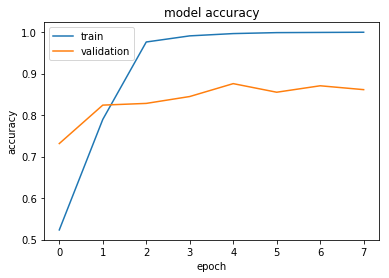

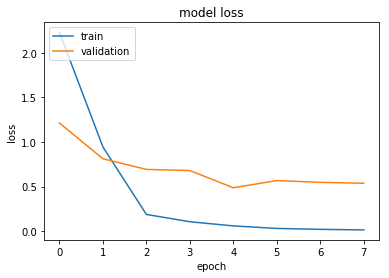

In [13]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
params = {'network_name': "inception_v3",
         'image_aug': False,
         'optimizer_name': "RMSprop", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 23s 1s/step - loss: 3.1712 - acc: 0.3130 - val_loss: 2.3388 - val_acc: 0.4609

Epoch 00001: val_acc improved from -inf to 0.46094, saving model to /data/oxford102/experiments/1548647838.127829/inception_v3_1548647838.127829.h5
Epoch 2/100
17/17 [==============================] - 18s 1s/step - loss: 2.0769 - acc: 0.5372 - val_loss: 1.8174 - val_acc: 0.6087

Epoch 00002: val_acc improved from 0.46094 to 0.60870, saving model to /data/oxford102/experiments/1548647838.127829/inception_v3_1548647838.127829.h5
Epoch 3/100
17/17 [==============================] - 18s 1s/step - loss: 1.2186 - acc: 0.7686 - val_loss: 1.5762 - val_acc: 0.6636

Epoch 00003: val_acc improved from 0.60870 to 0.66356, saving model to /data/oxford102/experiments/1548647838.127829/inception_v3_1548647838.127829.h5
Epoch 4/100
17/17 [==============================] - 16s 919ms/ste

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


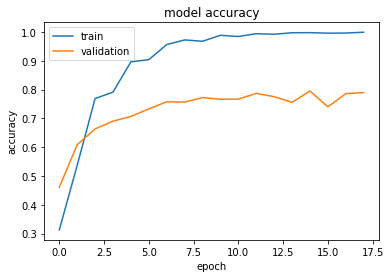

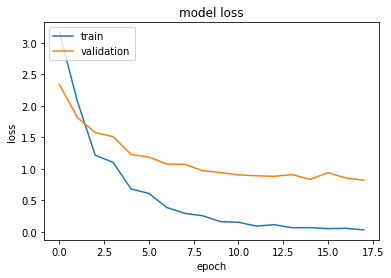

In [15]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [16]:
params = {'network_name': "densenet201",
         'image_aug': False,
         'optimizer_name': "RMSprop", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 46s 3s/step - loss: 2.6453 - acc: 0.4573 - val_loss: 1.5992 - val_acc: 0.6855

Epoch 00001: val_acc improved from -inf to 0.68555, saving model to /data/oxford102/experiments/1548648280.7698495/densenet201_1548648280.7698495.h5
Epoch 2/100
17/17 [==============================] - 37s 2s/step - loss: 1.3198 - acc: 0.7472 - val_loss: 1.0526 - val_acc: 0.8085

Epoch 00002: val_acc improved from 0.68555 to 0.80849, saving model to /data/oxford102/experiments/1548648280.7698495/densenet201_1548648280.7698495.h5
Epoch 3/100
17/17 [==============================] - 39s 2s/step - loss: 0.4735 - acc: 0.9417 - val_loss: 0.8211 - val_acc: 0.8613

Epoch 00003: val_acc improved from 0.80849 to 0.86128, saving model to /data/oxford102/experiments/1548648280.7698495/densenet201_1548648280.7698495.h5
Epoch 4/100
17/17 [==============================] - 33s 2s/ste

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


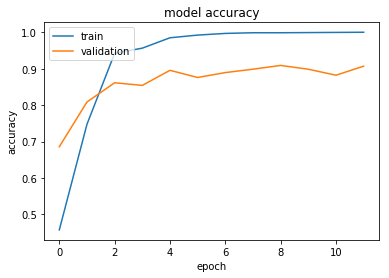

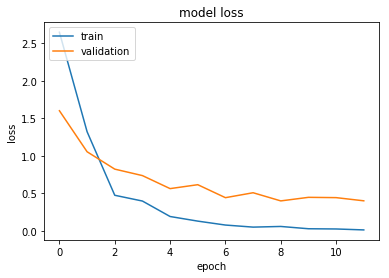

In [17]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "RMSprop", 
         'optimizer': optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:56: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 108s 6s/step - loss: 2.9721 - acc: 0.3575 - val_loss: 2.1373 - val_acc: 0.4883

Epoch 00001: val_acc improved from -inf to 0.48828, saving model to /data/oxford102/experiments/1548729631.9700549/nasnet_1548729631.9700549.h5
Epoch 2/100
17/17 [==============================] - 93s 5s/step - loss: 1.8448 - acc: 0.5478 - val_loss: 1.6034 - val_acc: 0.6190

Epoch 00002: val_acc improved from 0.48828 to 0.61905, saving model to /data/oxford102/experiments/1548729631.9700549/nasnet_1548729631.9700549.h5
Epoch 3/100
17/17 [==============================] - 94s 6s/step - loss: 0.8269 - acc: 0.8135 - val_loss: 1.4604 - val_acc: 0.6128

Epoch 00003: val_acc did not improve from 0.61905
Epoch 4/100
17/17 [==============================] - 91s 5s/step - loss: 0.7000 - acc: 0.8373 - val_loss: 1.3843 - val_acc: 0.6542

Epoch 00004: val_acc improved from 0.61905

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


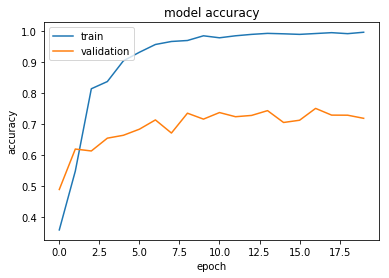

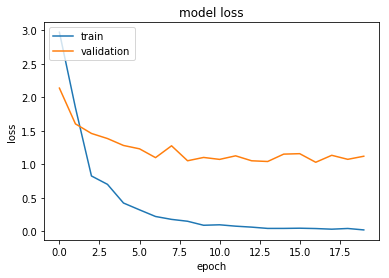

In [12]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 111, 111, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 111, 111, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 111, 111, 96) 0           stem_bn1[0][0]                   
__________________________________________________________________________________________________
reduction_

normal_add_3_8 (Add)            (None, 14, 14, 336)  0           normal_left3_8[0][0]             
                                                                 adjust_bn_8[0][0]                
__________________________________________________________________________________________________
normal_add_4_8 (Add)            (None, 14, 14, 336)  0           normal_left4_8[0][0]             
                                                                 normal_right4_8[0][0]            
__________________________________________________________________________________________________
normal_add_5_8 (Add)            (None, 14, 14, 336)  0           separable_conv_2_bn_normal_left5_
                                                                 normal_bn_1_8[0][0]              
__________________________________________________________________________________________________
normal_concat_8 (Concatenate)   (None, 14, 14, 2016) 0           adjust_bn_8[0][0]                
          

In [18]:
for i, layer in enumerate(_model.layers):
    print(i, layer.name)


0 input_1
1 stem_conv1
2 stem_bn1
3 activation_1
4 reduction_conv_1_stem_1
5 reduction_bn_1_stem_1
6 activation_2
7 activation_4
8 separable_conv_1_pad_reduction_left1_stem_1
9 separable_conv_1_pad_reduction_right1_stem_1
10 separable_conv_1_reduction_left1_stem_1
11 separable_conv_1_reduction_right1_stem_1
12 separable_conv_1_bn_reduction_left1_stem_1
13 separable_conv_1_bn_reduction_right1_stem_1
14 activation_3
15 activation_5
16 separable_conv_2_reduction_left1_stem_1
17 separable_conv_2_reduction_right1_stem_1
18 activation_6
19 separable_conv_2_bn_reduction_left1_stem_1
20 separable_conv_2_bn_reduction_right1_stem_1
21 separable_conv_1_pad_reduction_right2_stem_1
22 activation_8
23 reduction_add_1_stem_1
24 separable_conv_1_reduction_right2_stem_1
25 separable_conv_1_pad_reduction_right3_stem_1
26 activation_10
27 separable_conv_1_bn_reduction_right2_stem_1
28 separable_conv_1_reduction_right3_stem_1
29 separable_conv_1_reduction_left4_stem_1
30 activation_7
31 separable_conv_1_b

In [20]:
for layer in _model.layers[1019:]:
    layer.trainable = True

In [21]:
optimizer = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

In [22]:
params = {'network_name': "nasnet",
         'image_aug': False,
         'optimizer_name': "SGD", 
         'optimizer': optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True),
         'optimizer_params': None, 
         'batch_size': 128,
         'epochs': 100,
         'image_size': (224, 224),
         'log_time': None}

#_model, input_processor = get_model(params["network_name"], image_size=params["image_size"])
train_generator, validation_generator = get_generators( params["batch_size"], params["image_size"], input_processor)
history = train_model(params, _model, (train_generator, validation_generator))

Found 4604 images belonging to 102 classes.
Found 1094 images belonging to 102 classes.
Epoch 1/100
17/17 [==============================] - 104s 6s/step - loss: 0.0184 - acc: 0.9972 - val_loss: 1.0903 - val_acc: 0.7334

Epoch 00001: val_acc improved from -inf to 0.73340, saving model to /data/oxford102/experiments/1548734742.7303333/nasnet_1548734742.7303333.h5
Epoch 2/100
17/17 [==============================] - 92s 5s/step - loss: 0.0139 - acc: 0.9977 - val_loss: 1.0475 - val_acc: 0.7464

Epoch 00002: val_acc improved from 0.73340 to 0.74638, saving model to /data/oxford102/experiments/1548734742.7303333/nasnet_1548734742.7303333.h5
Epoch 3/100
17/17 [==============================] - 92s 5s/step - loss: 0.0125 - acc: 0.9986 - val_loss: 1.1614 - val_acc: 0.7226

Epoch 00003: val_acc did not improve from 0.74638
Epoch 4/100
17/17 [==============================] - 92s 5s/step - loss: 0.0113 - acc: 0.9995 - val_loss: 1.0366 - val_acc: 0.7474

Epoch 00004: val_acc improved from 0.74638

In [ ]:
def train_model(params, _model, generators):
    model_name = params["network_name"]
    num_train_img = 4604
    num_val_img = 1094

    np.random.seed(seed)
    log_time = time()
    params['log_time'] = log_time
    batch_size = params.get("batch_size")

    train_generator, validation_generator = generators
    _model.compile(loss = "categorical_crossentropy", optimizer = params["optimizer"], metrics=["accuracy"])


    base = '/data/oxford102/experiments'
    path = os.path.join(base, str(log_time))
    checkpoint = ModelCheckpoint(os.path.join(path, "{}_{}.h5".format(model_name, log_time)), monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    early = EarlyStopping(monitor='val_acc', min_delta=0, patience=3, verbose=1, mode='auto')
    tensorboard = TensorBoard(log_dir="logs/{}".format(log_time), histogram_freq=0, write_graph=True, write_images=True)
    csv_logger = CSVLogger(os.path.join(path, "{}_{}.csv".format(model_name, log_time)), append=True, separator=';')

    try:
        if not os.path.exists(path):
            os.makedirs(path)
        history_callback = _model.fit_generator(
                train_generator,
                steps_per_epoch=num_train_img // params["batch_size"] // 2,
                epochs=params["epochs"],
                validation_data=validation_generator,
                validation_steps=num_val_img // params["batch_size"],
                callbacks = [checkpoint, early, tensorboard, csv_logger])
    except Exception as e:
        raise(e)
    finally:
        params.pop("optimizer")
        pk.dump(params, open("experimental_params/experiments_{}.pk".format(log_time), "wb"), protocol=pk.HIGHEST_PROTOCOL)
        _model.save_weights(os.path.join(path, 'model_{}_weights_final_{}.h5'.format(model_name, log_time)))  # always save your weights after training or during training
        print(params)
        params
    return history_callback